In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

In [36]:
# Load CSV files\
df_data = pd.read_csv('pandas/df_data.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered.csv')

agg_df_cluster1 = pd.read_csv('pandas/agg_df_cluster1.csv')
fish_df_cluster1 = pd.read_csv('pandas/fish_df_cluster1.csv')
#agg_df_large = pd.read_csv('pandas/agg_df_large_cluster.csv')
#fish_df_large = pd.read_csv('pandas/fish_df_large_cluster.csv')
#agg_df_top2 = pd.read_csv('pandas/agg_df_top2.csv')
#fish_df_top2 = pd.read_csv('pandas/fish_df_top2.csv')

agg_df_cluster2 = pd.read_csv('pandas/agg_df_cluster2.csv')
fish_df_cluster2 = pd.read_csv('pandas/fish_df_cluster2.csv')

In [37]:
# designate which clustering to analyze
df_explore = agg_df_cluster2 # agg_df or agg_df_large or agg_df_top2
fish_explore = fish_df_cluster2 # fish_df or fish_df_large or fish_df_top2


Cluster sizes:
cluster
1     1987
2      127
3       54
4       48
5       22
6       12
7       10
8       10
9        5
10       2
11       1
dtype: int64


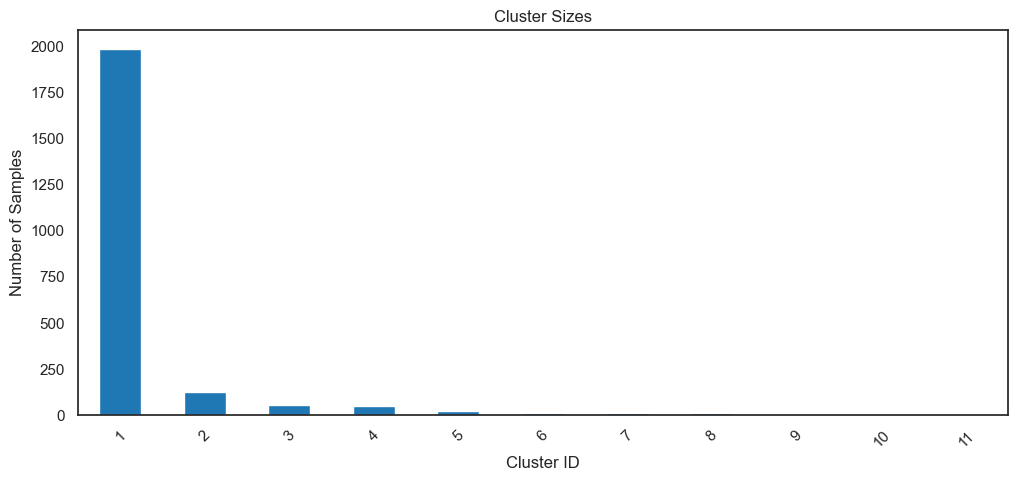

In [38]:
# Summary of clusters
cluster_summary = df_explore.groupby('cluster').size().sort_values(ascending=False)
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title('Cluster Sizes')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

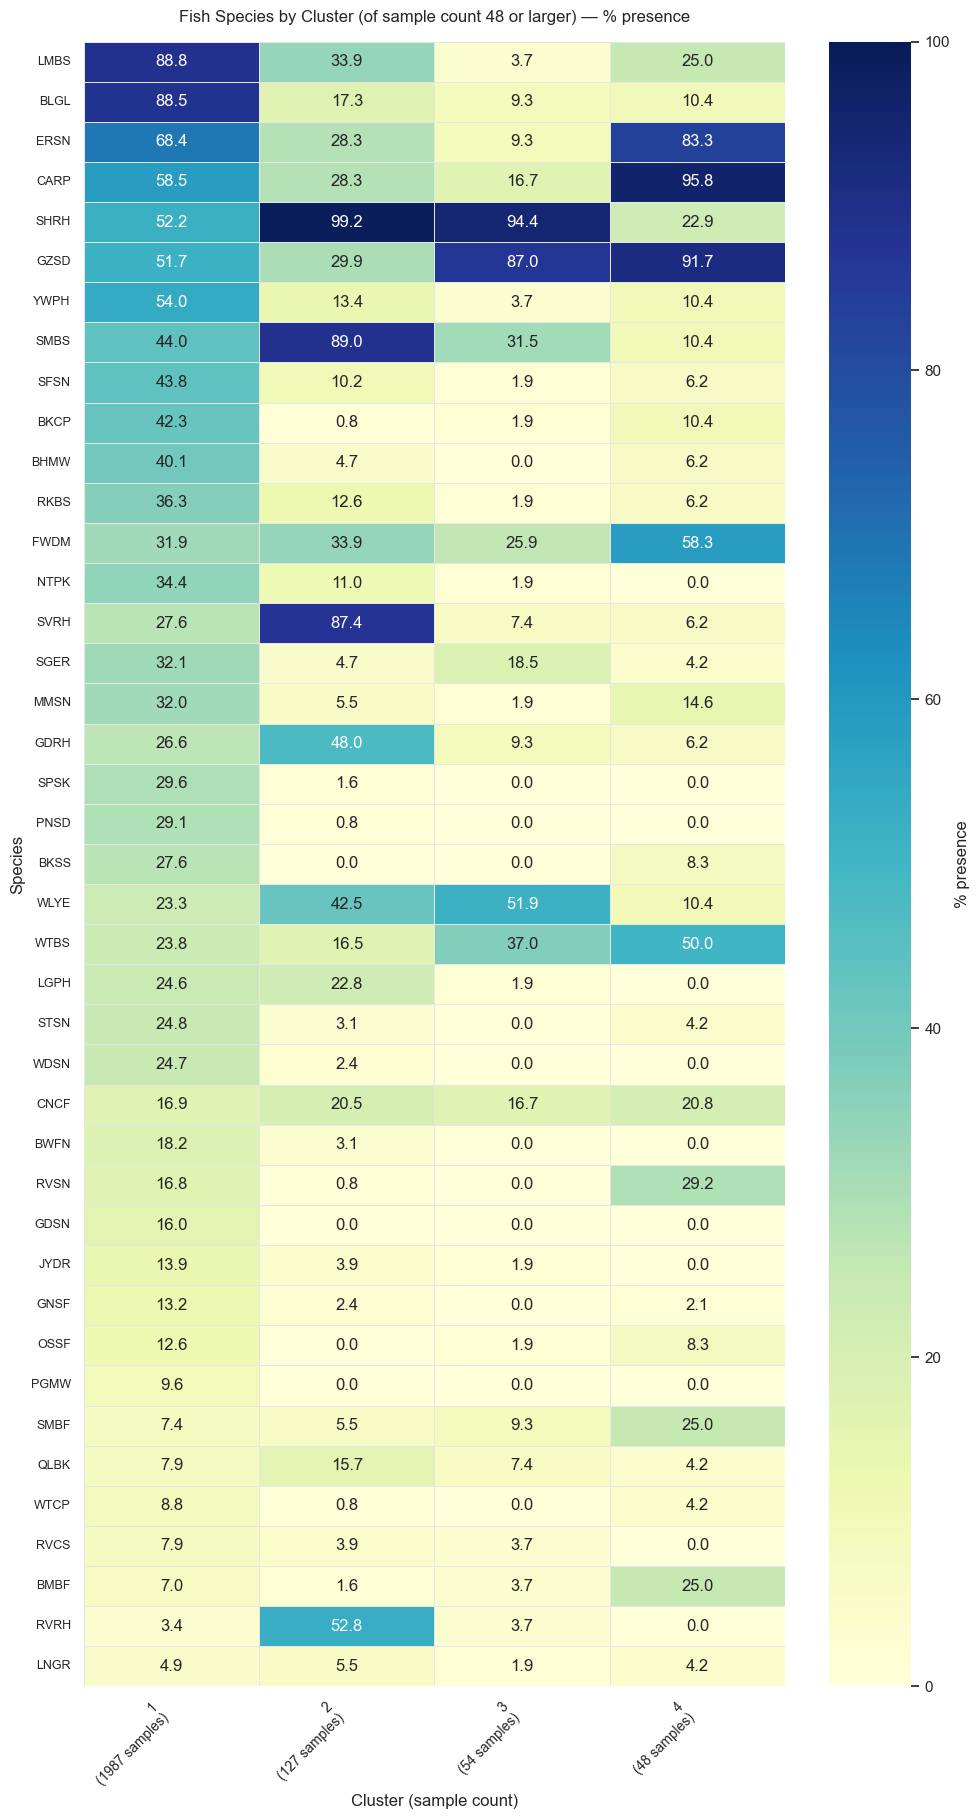

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("notebook", font_scale=1.0)

# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_order = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Keep only top 20 most common species
fishcode_2_include = 41
top_species = species_order[:fishcode_2_include]

# Compute percent presence per cluster for top 20 species only
# Result: rows = cluster, cols = species
jac_comp = fish_explore.groupby('cluster')[top_species].mean() * 100

# Order clusters by overall sample count (so columns are in meaningful order)
# Filter clusters with size >= 10
cluster_filter = 48
cluster_sizes = df_explore['cluster'].value_counts()
cluster_sizes = cluster_sizes[cluster_sizes >= cluster_filter]
cluster_order = [c for c in cluster_sizes.index if c in jac_comp.index]
jac_comp = jac_comp.reindex(cluster_order)

# Transpose so rows=species, cols=cluster (more natural for reading species)
display_df = jac_comp.T

# Create readable cluster labels with site counts
col_labels = [f"{c}\n({cluster_sizes.get(c,0)} samples)" for c in display_df.columns]

# Plot
fig, ax = plt.subplots(figsize=(max(10, 0.6 * display_df.shape[1]), 0.35 * display_df.shape[0] + 4))
cmap = sns.color_palette("YlGnBu", as_cmap=True)  # perceptually-uniform sequential

sns.heatmap(
    display_df,
    ax=ax,
    cmap=cmap,
    vmin=0,
    vmax=100,
    annot=True,
    fmt=".1f",
    linewidths=0.4,
    linecolor="0.9",
    cbar_kws={"label": "% presence"}
)

ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_xlabel("Cluster (sample count)")
ax.set_ylabel("Species")
ax.set_title(f"Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
#ax.set_title(f"Top {fishcode_2_include} Most Common Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
plt.tight_layout()
plt.show()
fig.savefig(
    'cluster_species_presence2.jpg',
    dpi=300,
    bbox_inches='tight',
    format='jpeg',
    pil_kwargs={'quality': 95, 'optimize': True, 'progressive': True}
)

In [40]:
# Specify cluster to analyze
cluster_num = 1

# Filter data for this cluster
cluster_data = df_explore[df_explore['cluster'] == cluster_num]
cluster_fish_data = df_filtered[df_filtered['barcode'].isin(cluster_data['barcode'])]

# Environmental variables summary (median)
env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
env_summary = cluster_data[env_vars].median()

# Categorical variables summary (mode)
cat_vars = ['mode_substrt']
cat_summary = cluster_data[cat_vars].mode().iloc[0]

# Binary variables summary (proportion present)
binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
binary_summary = cluster_data[binary_vars].mean()

# Fish species counts
fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
species_counts = fish_in_cluster.sum().sort_values(ascending=False)
species_counts = species_counts[species_counts > 0]

cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

# Total individuals caught
fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
#fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

# Number of samples where present
fish_occurrence = fish_in_cluster.sum()

# Combine
species_summary = pd.DataFrame({
    'total_caught': fish_abundance,
    'samples': fish_occurrence,
    'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
}).fillna(0).astype({'total_caught': int, 'samples': int})
species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)

# Print summary
print(f"=== CLUSTER {cluster_num} SUMMARY ===")
print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
print("\n--- Environmental Variables (Median) ---")
print(env_summary)
print("\n--- Categorical Variables (Mode) ---")
print(cat_summary)
print("\n--- Binary Variables (Proportion Present) ---")
print(binary_summary)
print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 1987

--- Environmental Variables (Median) ---
median_temp        14.90
median_depth        1.00
median_current      0.07
median_esveg92      1.00
median_cond       391.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    3.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.665657
riprap_present     0.181818
inout_present      0.056566
flooded_present    0.111616
dtype: float64

--- Fish Species (Count of 1987 samples) ---
      total_caught  samples  mean_length
LMBS         21199     1764        179.8
BLGL         20884     1759         98.1
ERSN          5956     1359         53.0
CARP          7882     1163        535.6
YWPH          7251     1073        131.6
...            ...      ...          ...
BNDR             1        1         41.0
LSSR             1        1         79.0
PDFH             1        1       1400.0
RESF             1        1        

In [41]:
# Summarize all clusters at once
for cluster_num in sorted(df_explore['cluster'].unique()):
    cluster_data = df_explore[df_explore['cluster'] == cluster_num]
    cluster_fish_data = df_data[df_data['barcode'].isin(cluster_data['barcode'])]
    
    # Environmental variables summary (median)
    env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
    env_summary = cluster_data[env_vars].median()

    # Categorical variables summary (mode)
    cat_vars = ['mode_substrt']
    cat_summary = cluster_data[cat_vars].mode().iloc[0]

    # Binary variables summary (proportion present)
    binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
    binary_summary = cluster_data[binary_vars].mean()

    # Fish species counts
    fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
    species_counts = fish_in_cluster.sum().sort_values(ascending=False)
    species_counts = species_counts[species_counts > 0]

    cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

    # Total individuals caught
    fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
    fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
    #fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

    # Number of samples where present
    fish_occurrence = fish_in_cluster.sum()

    # Combine
    species_summary = pd.DataFrame({
        'total_caught': fish_abundance,
        'samples': fish_occurrence,
        'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
    }).fillna(0).astype({'total_caught': int, 'samples': int})
    species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)


    # Print summary
    print(f"=== CLUSTER {cluster_num} SUMMARY ===")
    print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
    print("\n--- Environmental Variables (Median) ---")
    print(env_summary)
    print("\n--- Categorical Variables (Mode) ---")
    print(cat_summary)
    print("\n--- Binary Variables (Proportion Present) ---")
    print(binary_summary)
    print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
    print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 1987

--- Environmental Variables (Median) ---
median_temp        14.90
median_depth        1.00
median_current      0.07
median_esveg92      1.00
median_cond       391.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    3.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.665657
riprap_present     0.181818
inout_present      0.056566
flooded_present    0.111616
dtype: float64

--- Fish Species (Count of 1987 samples) ---
      total_caught  samples  mean_length
LMBS         21199     1764        179.8
BLGL         20884     1759         98.1
ERSN          5956     1359         53.0
CARP          7882     1163        535.6
YWPH          7251     1073        131.6
...            ...      ...          ...
BNDR             1        1         41.0
LSSR             1        1         79.0
PDFH             1        1       1400.0
RESF             1        1        

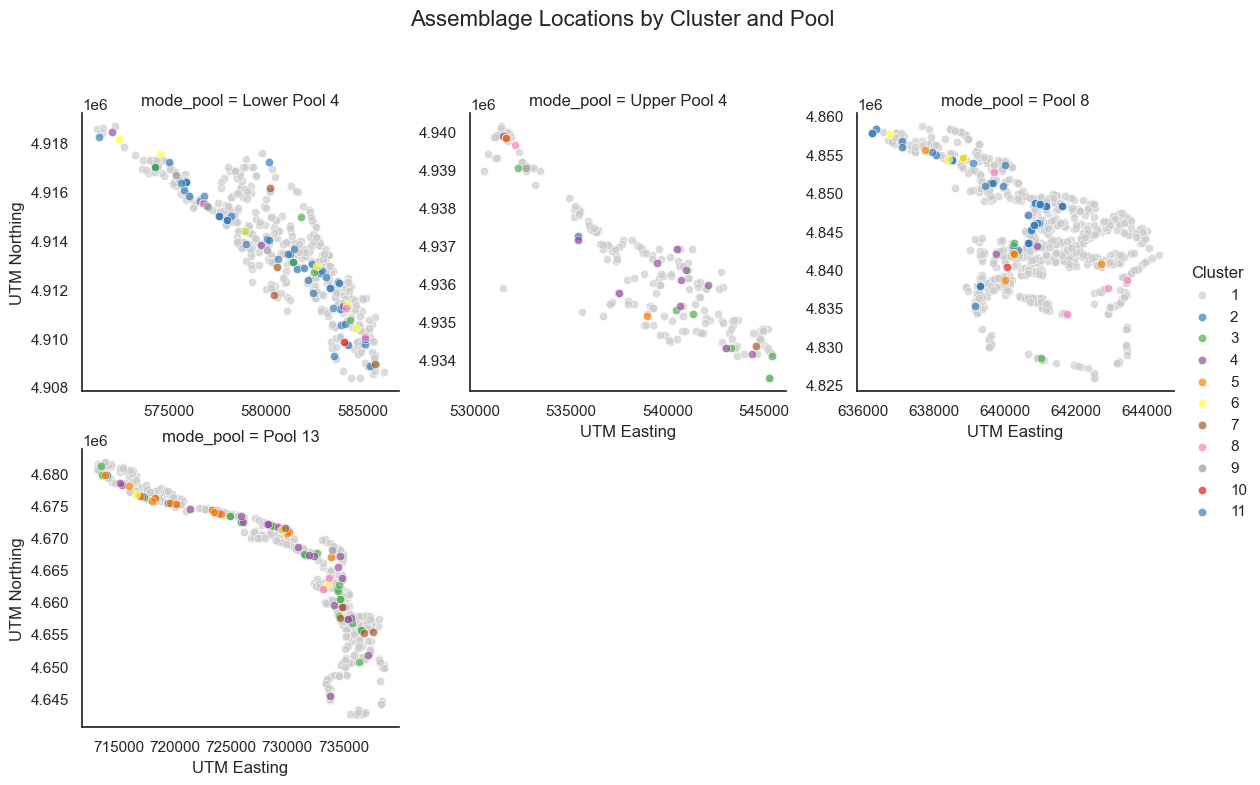

In [42]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    df_explore,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool", fontsize=16)
plt.show()

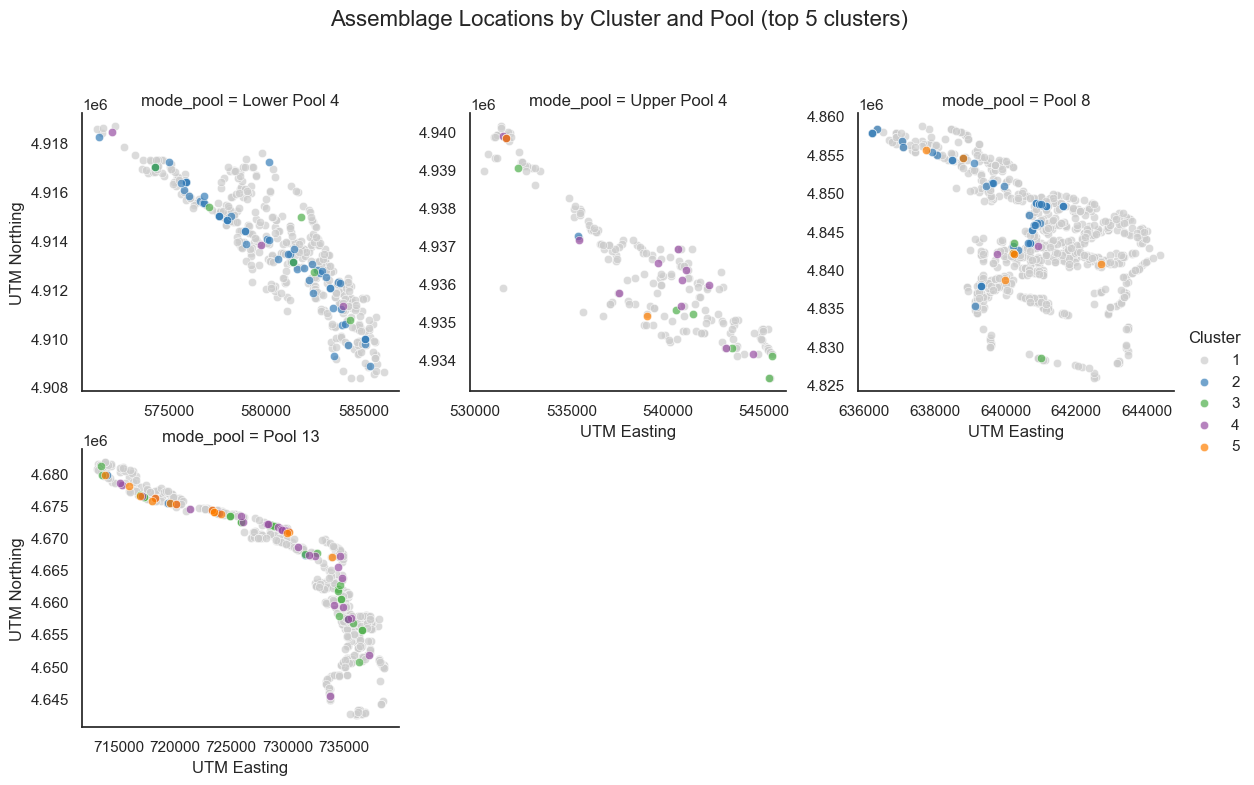

In [43]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    df_explore[df_explore['cluster'].isin(range(6))],
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool (top 5 clusters)", fontsize=16)
plt.show()

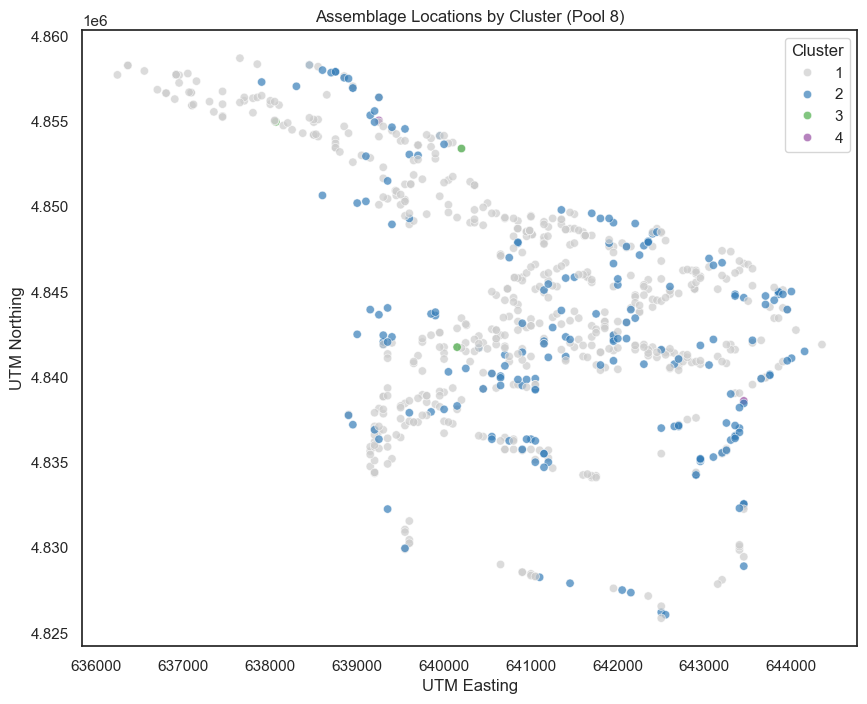

In [ ]:
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = cluster_sizes.idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

#####
# Filter by specified pool
#####
pool_filter = 'Pool 8'  # Change this to desired pool value
available_pools = sorted(df_explore['mode_pool'].unique().tolist())

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()

    # Plot using the same color_map as the global plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_pool,
        x="utm_e",
        y="utm_n",
        hue="cluster",
        palette=color_map,
        alpha=0.7
    )
    plt.xlabel("UTM Easting")
    plt.ylabel("UTM Northing")
    plt.title(f"Assemblage Locations by Cluster ({pool_filter})")
    plt.legend(title="Cluster")
    plt.show()

## <a id='toc2_2_'></a>[Cluster Characteristics](#toc0_)

We next inspected how each cluster varied in it’s species composition.

We will produce three vertical heatmaps for the Jaccard clustering method. Each heatmap shows the average percent presence of each fish species (rows) within each cluster (columns).

*What the graph means:*

-   **Columns**: Each column is a cluster of assemblages (sites grouped by fish community similarity).
-   **Rows**: Each row is a fish species (only those present in >10% of any cluster).
-   **Cell values**: The number in each cell is the percent of assemblages in that cluster where the species is present (0–100%).
-   **Color**: Darker blue = higher percent presence.
-   **Interpretation**: You can see which species are common or rare in each cluster, and how species composition differs between clusters and clustering methods.

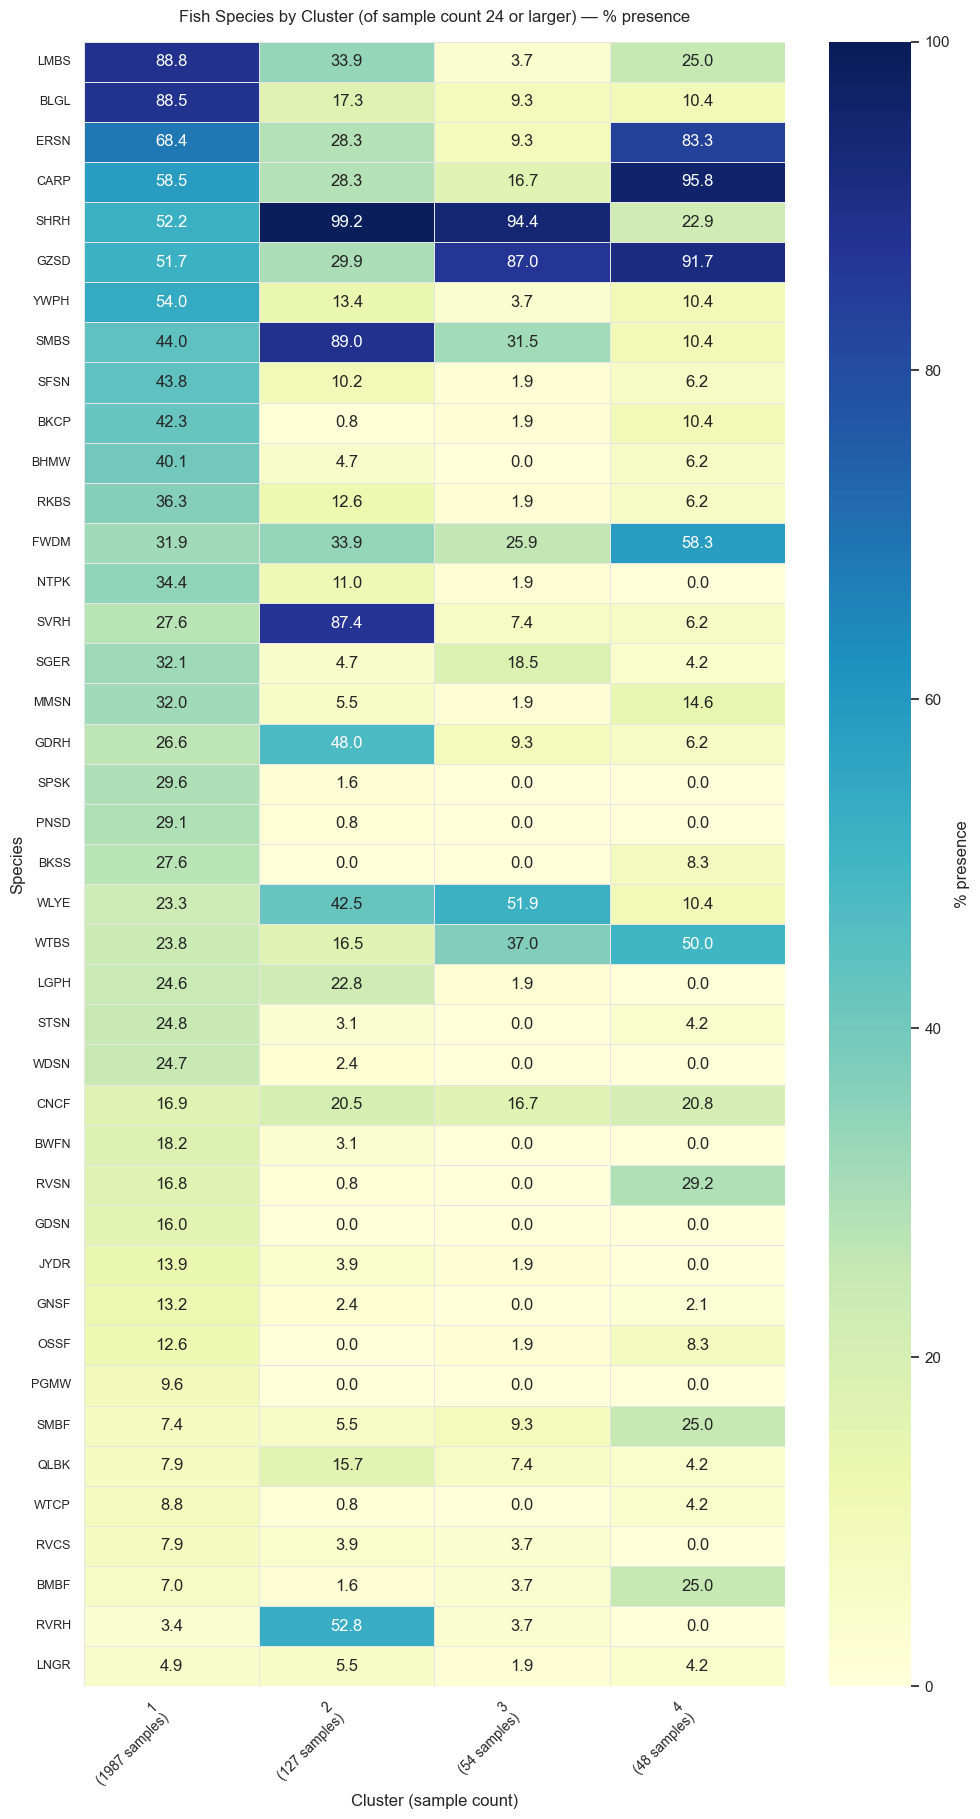

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("notebook", font_scale=1.0)

# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_order = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Keep only top 20 most common species
fishcode_2_include = 41
top_species = species_order[:fishcode_2_include]

# Compute percent presence per cluster for top 20 species only
# Result: rows = cluster, cols = species
jac_comp = fish_explore.groupby('cluster')[top_species].mean() * 100

# Order clusters by overall sample count (so columns are in meaningful order)
# Filter clusters with size >= 10
cluster_filter = 24
cluster_sizes = df_explore['cluster'].value_counts()
cluster_sizes = cluster_sizes[cluster_sizes >= cluster_filter]
cluster_order = [c for c in cluster_sizes.index if c in jac_comp.index]
jac_comp = jac_comp.reindex(cluster_order)

# Transpose so rows=species, cols=cluster (more natural for reading species)
display_df = jac_comp.T

# Create readable cluster labels with site counts
col_labels = [f"{c}\n({cluster_sizes.get(c,0)} samples)" for c in display_df.columns]

# Plot
fig, ax = plt.subplots(figsize=(max(10, 0.6 * display_df.shape[1]), 0.35 * display_df.shape[0] + 4))
cmap = sns.color_palette("YlGnBu", as_cmap=True)  # perceptually-uniform sequential

sns.heatmap(
    display_df,
    ax=ax,
    cmap=cmap,
    vmin=0,
    vmax=100,
    annot=True,
    fmt=".1f",
    linewidths=0.4,
    linecolor="0.9",
    cbar_kws={"label": "% presence"}
)

ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_xlabel("Cluster (sample count)")
ax.set_ylabel("Species")
ax.set_title(f"Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
#ax.set_title(f"Top {fishcode_2_include} Most Common Fish Species by Cluster (of sample count {cluster_filter} or larger) — % presence", pad=14)
plt.tight_layout()
plt.show()
fig.savefig(
    'cluster_species_presence.jpg',
    dpi=300,
    bbox_inches='tight',
    format='jpeg',
    pil_kwargs={'quality': 95, 'optimize': True, 'progressive': True}
)

Cluster analysis on top 2 clusters

### Caption for Cell 13 heatmap figure

Figure X. Species presence patterns across fish assemblage clusters. 
Heatmap shows the percentage of sampling sites where each of the 10 most 
frequently occurring species was present within each cluster (n = 2,134 sites). 
Cell values represent percent occurrence (0-100%), with darker blue indicating 
higher prevalence. Clusters are ordered by sample size (shown in parentheses). 
Species codes: LMBS = Largemouth Bass, BLGL = Bluegill, ERSN = Emerald Shiner, 
CARP = Common Carp, GZSD = Gizzard Shad, YWPH = Yellow Perch, SHRH = Shorthead 
Redhorse, SMBS = Smallmouth Bass, SFSN = Spotfin Shiner, BKCP = Black Crappie. 
Distinct assemblage compositions are evident, with Cluster 1 and 2 showing 
contrasting species dominance patterns despite both being well-sampled.

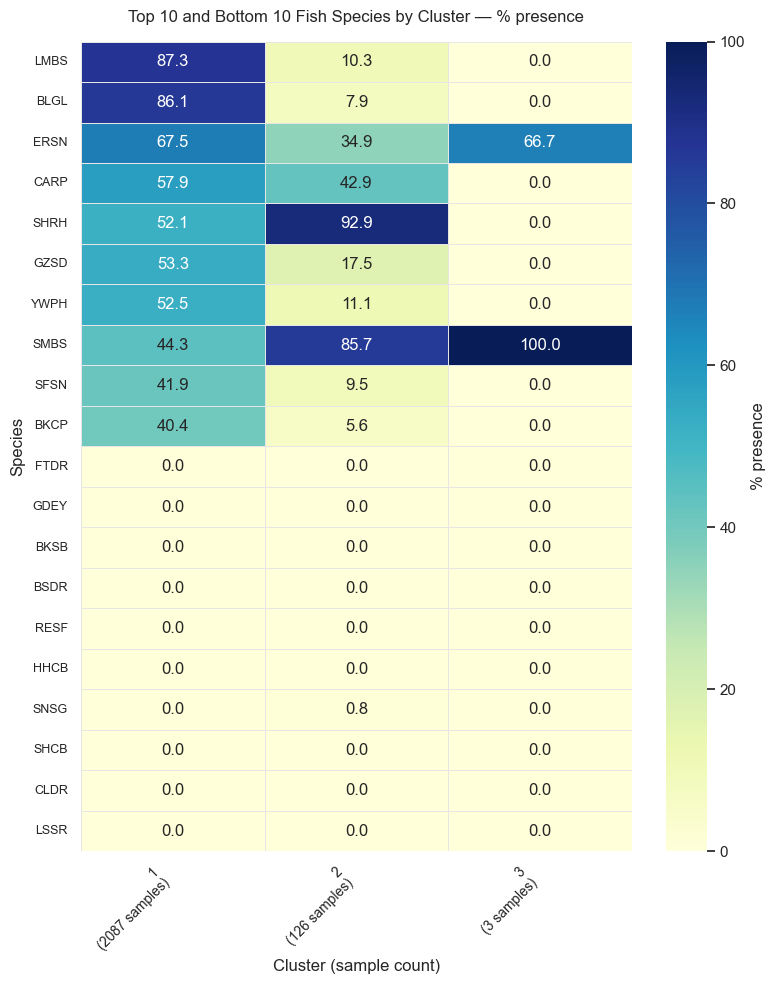

In [12]:
# ...existing code...
# Top-5 and bottom-5 species heatmap — cluster counts and improved styling
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("notebook", font_scale=1.0)

# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_counts = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False)

top_n = 10
bottom_n = 10

top_species = list(species_counts.index[:top_n])
# choose least-common among species that occur at least once
bottom_candidates = species_counts[species_counts > 0].sort_values(ascending=True)
bottom_species = list(bottom_candidates.index[:bottom_n])

# preserve order and avoid duplicates (top species first)
selected = []
for s in top_species + bottom_species:
    if s not in selected:
        selected.append(s)

# Compute percent presence per cluster for selected species
# Result: rows = cluster, cols = species
jac_comp = fish_explore.groupby('cluster')[selected].mean() * 100

# Order clusters by overall sample count (so columns are in meaningful order)
cluster_sizes = df_explore['cluster'].value_counts()
cluster_order = [c for c in cluster_sizes.index if c in jac_comp.index]
jac_comp = jac_comp.reindex(cluster_order)

# Transpose so rows=species, cols=cluster (more natural for reading species)
display_df = jac_comp.T

# Create readable cluster labels with site counts
col_labels = [f"{c}\n({cluster_sizes.get(c,0)} samples)" for c in display_df.columns]

# Plot
fig, ax = plt.subplots(figsize=(max(8, 0.6 * display_df.shape[1]), 0.35 * display_df.shape[0] + 3))
cmap = sns.color_palette("YlGnBu", as_cmap=True)  # perceptually-uniform sequential

sns.heatmap(
    display_df,
    ax=ax,
    cmap=cmap,
    vmin=0,
    vmax=100,
    annot=True,
    fmt=".1f",
    linewidths=0.4,
    linecolor="0.9",
    cbar_kws={"label": "% presence"}
)

ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_xlabel("Cluster (sample count)")
ax.set_ylabel("Species")
ax.set_title(f"Top {top_n} and Bottom {bottom_n} Fish Species by Cluster — % presence", pad=14)
plt.tight_layout()
plt.show()
# ...existing code...

## Clusters over time

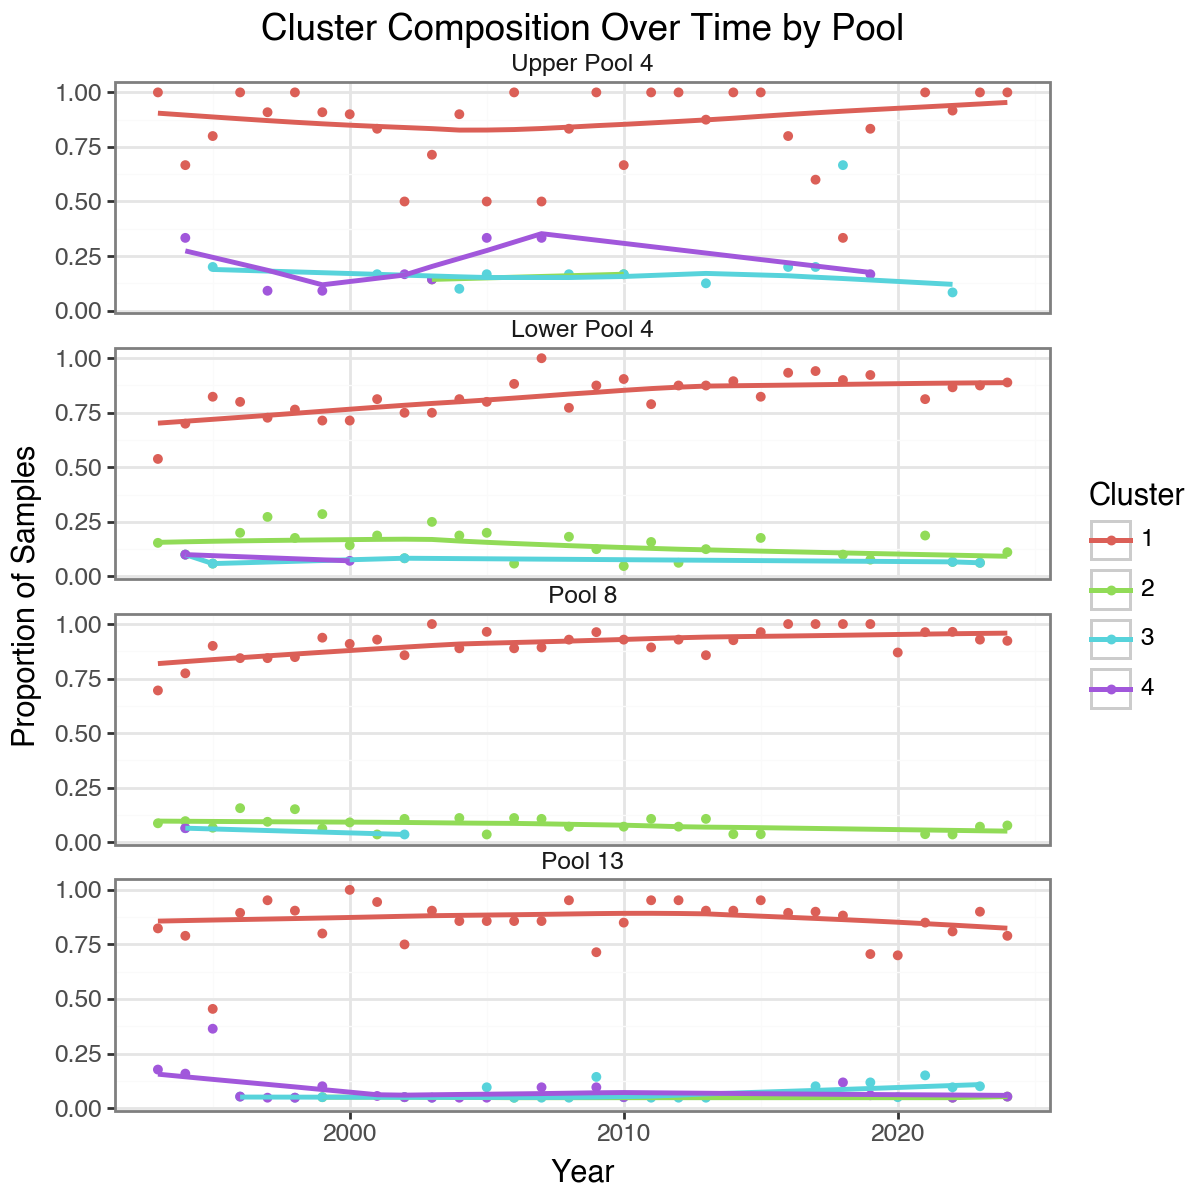

In [45]:
from plotnine import *

# Calculate proportion of samples in each cluster per year
cluster_time = df_explore.groupby(['year', 'cluster']).size().reset_index(name='count')
total_per_year = cluster_time.groupby('year')['count'].transform('sum')
cluster_time['proportion'] = cluster_time['count'] / total_per_year
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Calculate proportion per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
total_per_year_pool = cluster_time_pool.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_time_pool['proportion'] = cluster_time_pool['count'] / total_per_year_pool
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
grp_size2 = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = cluster_time_pool[grp_size2 >= 2]

# ensure desired pool order and filter to clusters < 5
desired_order = ["Upper Pool 4", "Lower Pool 4", "Pool 8", "Pool 13"]

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
grp_size2 = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = cluster_time_pool[grp_size2 >= 2]

cluster_filter = [1,2,3,4]
cluster_time_pool_lt5 = cluster_time_pool[cluster_time_pool['cluster'].astype(int).isin(cluster_filter)].copy()
filtered_smooth_lt5 = filtered_smooth[filtered_smooth['cluster'].astype(int).isin(cluster_filter)].copy()

cluster_time_pool_lt5['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
filtered_smooth_lt5['mode_pool'] = pd.Categorical(filtered_smooth_lt5['mode_pool'], categories=desired_order, ordered=True)

# plot with facet order preserved
(ggplot(cluster_time_pool_lt5, aes(x='year', y='proportion', color='cluster')) +
 geom_point(size=1) +
 geom_smooth(data=filtered_smooth_lt5, method='lowess', se=False) +
 facet_wrap('~mode_pool', ncol=1) +
 labs(x='Year', y='Proportion of Samples', color='Cluster',
      title='Cluster Composition Over Time by Pool') +
 theme_bw()+
 theme(figure_size=(6, 6),
       strip_background = element_blank())
)

In [46]:
cluster_time_pool_lt5.head()

,year,cluster,mode_pool,count,proportion
0,1993,1,Lower Pool 4,7,0.538462
1,1993,1,Pool 13,14,0.823529
2,1993,1,Pool 8,16,0.695652
3,1993,1,Upper Pool 4,6,1.000000
4,1993,2,Lower Pool 4,2,0.153846


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import f as f_dist
from plotnine import *

# =====================================================================
# SEGMENTED REGRESSION FOR ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

def piecewise_linear(x, x0, y0, m1, m2):
    """
    Continuous piecewise linear function with breakpoint at x0.
    Left (x <= x0): y = y0 + m1*(x - x0)
    Right (x > x0): y = y0 + m2*(x - x0)
    """
    return np.piecewise(
        x,
        [x <= x0, x > x0],
        [lambda z: y0 + m1 * (z - x0),
         lambda z: y0 + m2 * (z - x0)]
    )

def fit_segmented_regression(years, proportions, min_points=6):
    """
    Fit continuous segmented regression with one breakpoint using curve_fit.
    
    Returns:
    --------
    dict with fit results or None if insufficient data
    """
    years = np.asarray(years, dtype=float)
    proportions = np.asarray(proportions, dtype=float)
    
    if len(years) < min_points:
        return None
    
    # Initial guesses
    x0_guess = np.median(years)
    y0_guess = proportions[np.argmin(np.abs(years - x0_guess))]
    m1_guess = 0.0
    m2_guess = 0.0
    p0 = [x0_guess, y0_guess, m1_guess, m2_guess]
    
    # Bounds: keep breakpoint inside observed range
    bounds = (
        [years.min(), -np.inf, -np.inf, -np.inf],
        [years.max(),  np.inf,  np.inf,  np.inf]
    )
    
    try:
        # Fit piecewise model
        params, cov = optimize.curve_fit(
            piecewise_linear,
            years, proportions,
            p0=p0,
            bounds=bounds,
            maxfev=10000
        )
        
        x0_fit, y0_fit, m1_fit, m2_fit = params
        y_hat = piecewise_linear(years, *params)
        rss_piece = np.sum((proportions - y_hat)**2)
        
        # Simple linear model for comparison
        slope_simple, intercept_simple = np.polyfit(years, proportions, 1)
        y_hat_simple = slope_simple * years + intercept_simple
        rss_simple = np.sum((proportions - y_hat_simple)**2)
        
        # F-test
        n = len(years)
        k_piece = 4  # x0, y0, m1, m2
        k_simple = 2
        
        if n > k_piece and rss_piece > 0:
            f_stat = ((rss_simple - rss_piece) / (k_piece - k_simple)) / (rss_piece / (n - k_piece))
            p_value = 1 - f_dist.cdf(f_stat, k_piece - k_simple, n - k_piece)
        else:
            f_stat = np.nan
            p_value = np.nan
        
        return {
            'breakpoint': x0_fit,
            'y_at_break': y0_fit,
            'slope_before': m1_fit,
            'slope_after': m2_fit,
            'rss_piecewise': rss_piece,
            'rss_simple': rss_simple,
            'improvement_pct': 100 * (rss_simple - rss_piece) / rss_simple if rss_simple > 0 else 0,
            'f_stat': f_stat,
            'p_value': p_value,
            'significant': (p_value < 0.05) if not np.isnan(p_value) else False,
            'n_points': n,
            'params': params,
            'cov': cov
        }
    
    except Exception as e:
        print(f"  Warning: Fit failed - {str(e)}")
        return None

# =====================================================================
# FIT ALL POOL-CLUSTER COMBINATIONS
# =====================================================================

results = []
fitted_data = []

for (pool, cluster), grp in cluster_time_pool_lt5.groupby(['mode_pool', 'cluster'], observed=False):
    # Sort and convert to numpy
    sub = grp[['year', 'proportion']].dropna().sort_values('year')
    years = sub['year'].to_numpy(dtype=float)
    props = sub['proportion'].to_numpy(dtype=float)
    
    res = fit_segmented_regression(years, props)
    
    if res:
        # Store results
        results.append({
            'mode_pool': pool,
            'cluster': cluster,
            'breakpoint_year': res['breakpoint'],
            'y_at_breakpoint': res['y_at_break'],
            'slope_before': res['slope_before'],
            'slope_after': res['slope_after'],
            'improvement_pct': res['improvement_pct'],
            'f_statistic': res['f_stat'],
            'p_value': res['p_value'],
            'significant': res['significant'],
            'n_points': res['n_points']
        })
        
        # Generate fitted values for plotting
        y_fitted = piecewise_linear(years, *res['params'])
        for yr, y_fit in zip(years, y_fitted):
            fitted_data.append({
                'mode_pool': pool,
                'cluster': cluster,
                'year': yr,
                'fitted': y_fit
            })

# Convert to DataFrames
segmented_results_df = pd.DataFrame(results).sort_values(['mode_pool', 'cluster'])
fitted_values_df = pd.DataFrame(fitted_data)

Heat map for full dataset
Time series for % in each cluster (or at least the top 3 clusters)

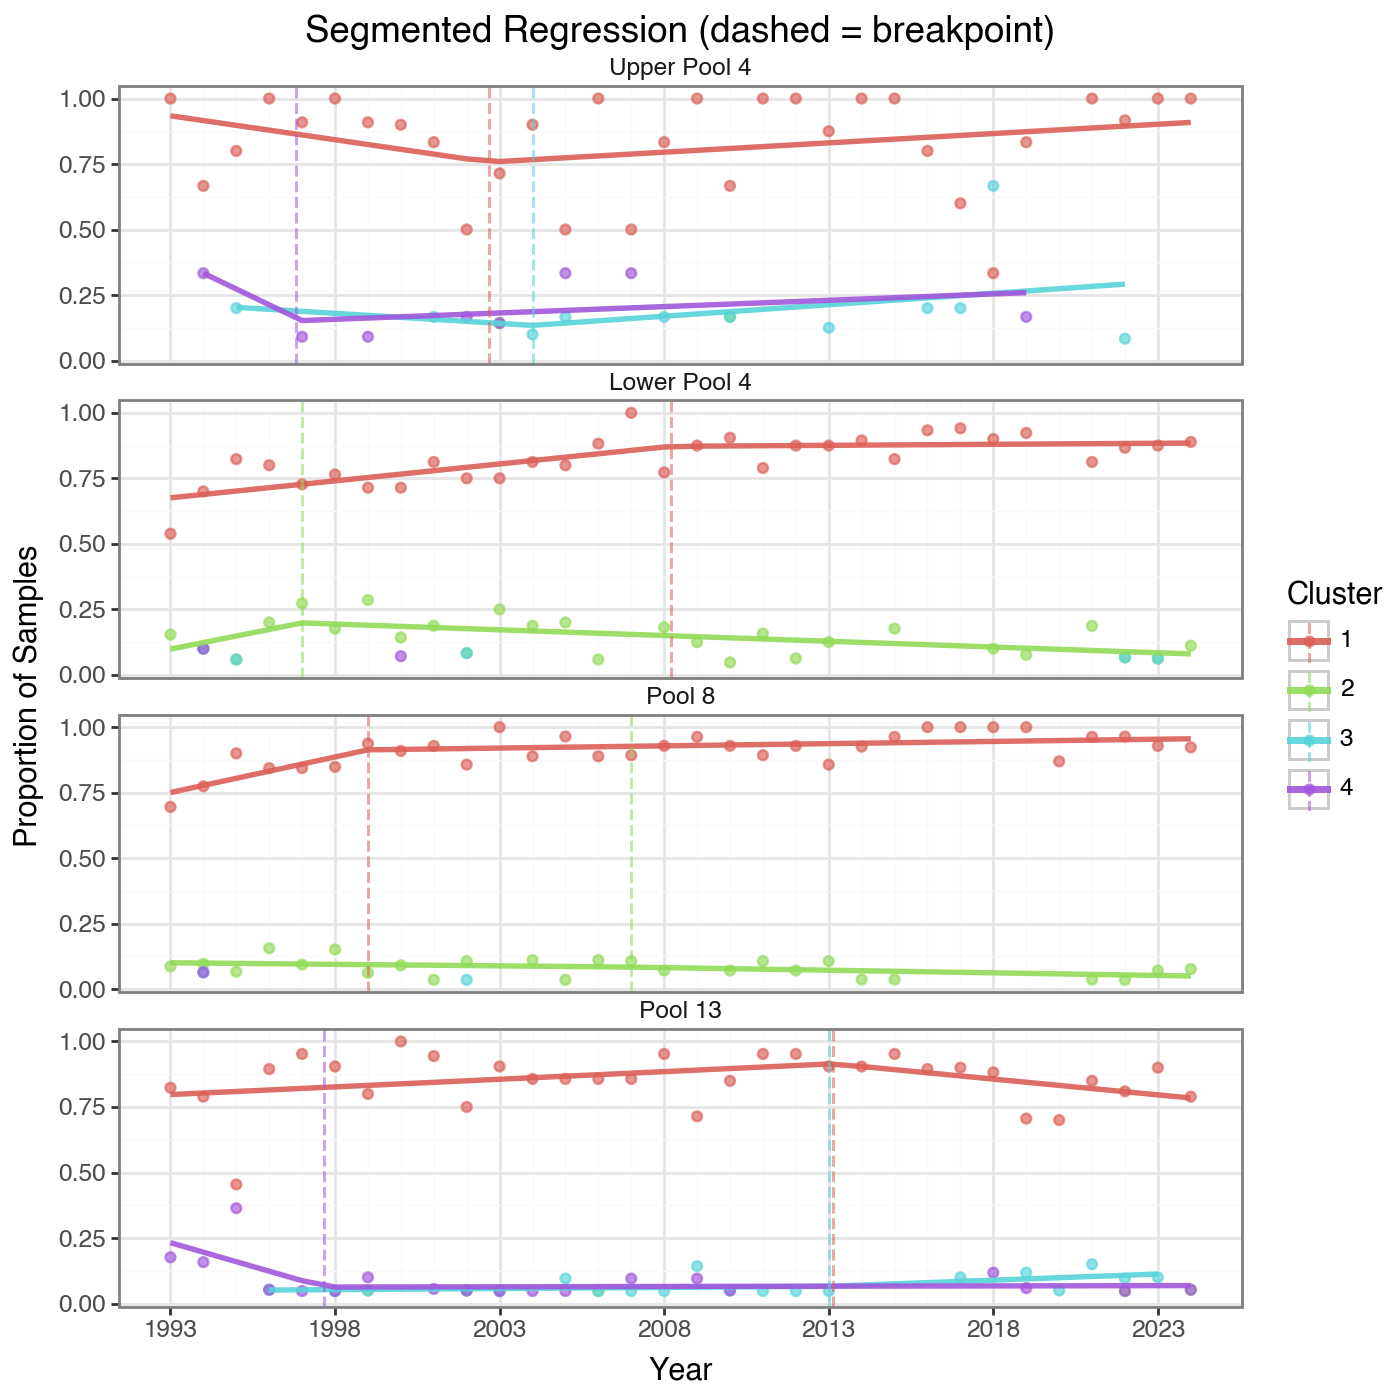

In [48]:
annotated_data = cluster_time_pool_lt5.merge(
     segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 'significant']],
     on=['mode_pool', 'cluster'],
     how='left'
)

annotated_data['mode_pool'] = pd.Categorical(cluster_time_pool_lt5['mode_pool'], categories=desired_order, ordered=True)
fitted_values_df['mode_pool'] = pd.Categorical(fitted_values_df['mode_pool'], categories=desired_order, ordered=True)
# Filter out rows with missing breakpoint_year for the vline layer
breakpoint_data = annotated_data.dropna(subset=['breakpoint_year'])

# Display plot
(
    ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
    geom_point(size=1.5, alpha=0.65) +
    geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
              size=1.1, alpha=0.9) +
    geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
               linetype='dashed', alpha=0.55, size=0.6) +
    facet_wrap('~mode_pool', ncol=1) +
    labs(x='Year', y='Proportion of Samples', color='Cluster',
         title='Segmented Regression (dashed = breakpoint)') +
    theme_bw() +
    theme(figure_size=(7, 7), strip_background=element_blank())
)
# Save the plot using ggsave
p = (
     ggplot(annotated_data, aes(x='year', y='proportion', color='cluster')) +
     geom_point(size=1.5, alpha=0.65) +
     geom_line(data=fitted_values_df, mapping=aes(x='year', y='fitted', color='cluster'),
                 size=1.1, alpha=0.9) +
     geom_vline(data=breakpoint_data, mapping=aes(xintercept='breakpoint_year', color='cluster'),
                  linetype='dashed', alpha=0.55, size=0.6) +
     facet_wrap('~mode_pool', ncol=1) +
     scale_x_continuous(minor_breaks=range(1993, 2024, 1), breaks=range(1993, 2024, 5)) +
     labs(x='Year', y='Proportion of Samples', color='Cluster',
           title='Segmented Regression (dashed = breakpoint)') +
     theme_bw() +
     theme(figure_size=(7, 7), strip_background=element_blank())
)

p.save('segmented_regression_clusters.jpg', dpi=300, verbose=False)
p.show()

In [55]:
# Create formatted table with F-stat and p-value
stats_table = segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year', 
                                     'f_statistic', 'p_value']].copy()

# Round values for readability
stats_table['breakpoint_year'] = stats_table['breakpoint_year'].round(1)
stats_table['f_statistic'] = stats_table['f_statistic'].round(2)
stats_table['p_value'] = stats_table['p_value'].round(4)

# Reorder rows to match desired pool order
stats_table['mode_pool'] = pd.Categorical(
    stats_table['mode_pool'], 
    categories=desired_order, 
    ordered=True
)
stats_table = stats_table.sort_values(['mode_pool', 'cluster'])

print("\n" + "=" * 60)
print("SEGMENTED REGRESSION STATISTICS")
print("=" * 60)
print(stats_table.to_string(index=False))


SEGMENTED REGRESSION STATISTICS
   mode_pool cluster  breakpoint_year  f_statistic  p_value
Upper Pool 4       1           2002.7         0.95   0.3980
Upper Pool 4       3           2004.0         0.16   0.8546
Upper Pool 4       4           1996.8         0.90   0.4771
Lower Pool 4       1           2008.2         3.02   0.0655
Lower Pool 4       2           1997.0         2.18   0.1361
      Pool 8       1           1999.0         6.95   0.0035
      Pool 8       2           2007.0         0.05   0.9549
     Pool 13       1           2013.1         1.93   0.1639
     Pool 13       3           2013.0         0.59   0.5671
     Pool 13       4           1997.7         3.93   0.0425


In [49]:
# Pivot table format
pivot_table = segmented_results_df.pivot(
    index='mode_pool', 
    columns='cluster', 
    values='breakpoint_year'
)
pivot_table = pivot_table.round(0).astype('Int64')

# Reorder rows to match desired_order
pivot_table = pivot_table.reindex(desired_order)

print("\n" + "=" * 60)
print("BREAKPOINT YEARS (Pools × Clusters)")
print("=" * 60)
print(pivot_table)


BREAKPOINT YEARS (Pools × Clusters)
cluster          1     2     3     4
mode_pool                           
Upper Pool 4  2003  <NA>  2004  1997
Lower Pool 4  2008  1997  <NA>  <NA>
Pool 8        1999  2007  <NA>  <NA>
Pool 13       2013  <NA>  2013  1998


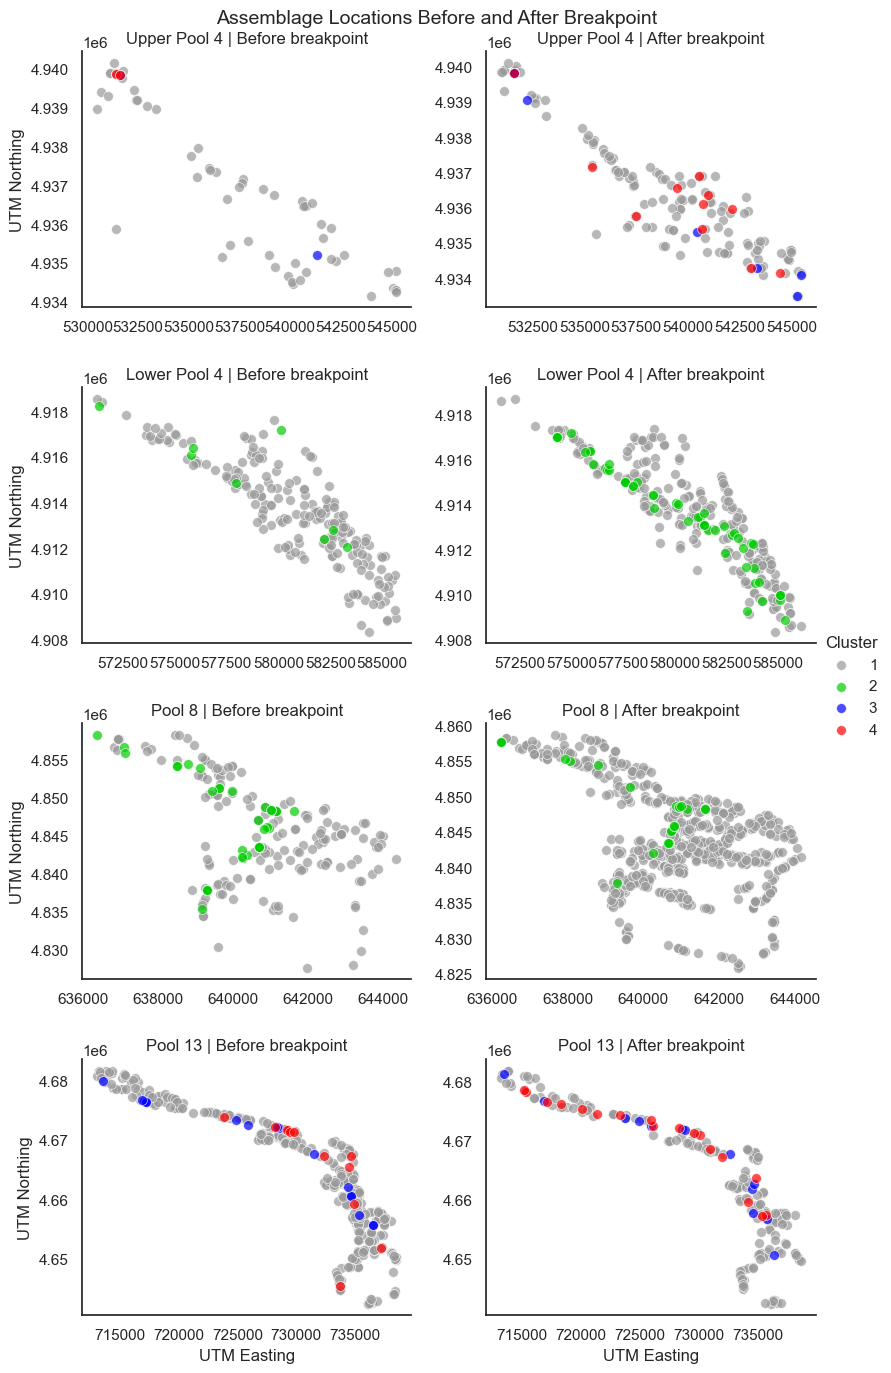

In [60]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())

# Custom color palette: cluster 1=grey, 2=green, 3=blue, 4 = red
custom_colors = {
    1: (0.6, 0.6, 0.6),  # grey
 #   1: (1.0, 0.0, 0.0),      # red
    2: (0.0, 0.8, 0.0),      # green
    3: (0.0, 0.0, 1.0),       # blue
    4: (1.0, 0.0, 0.0)       # red
}

# For other clusters, use default palette
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
color_map = {}
palette_idx = 0
for c in unique_clusters:
    if c in custom_colors:
        color_map[c] = custom_colors[c]
    else:
        color_map[c] = palette[palette_idx]
        palette_idx += 1

# Ensure cluster dtype matches between df_explore and segmented_results_df to avoid merge errors
if 'cluster' in segmented_results_df.columns:
    target_dtype = df_explore['cluster'].dtype
    if segmented_results_df['cluster'].dtype != target_dtype:
        # If df_explore cluster is integer-like, cast segmented_results_df cluster to int
        if np.issubdtype(target_dtype, np.integer):
            segmented_results_df = segmented_results_df.copy()
            segmented_results_df['cluster'] = segmented_results_df['cluster'].astype(int)
        else:
            # otherwise cast to the same dtype as df_explore
            segmented_results_df = segmented_results_df.copy()
            segmented_results_df['cluster'] = segmented_results_df['cluster'].astype(target_dtype)

# Merge breakpoint data with df_explore
df_with_breakpoints = df_explore.merge(
    segmented_results_df[['mode_pool', 'cluster', 'breakpoint_year']],
    on=['mode_pool', 'cluster'],
    how='left'
)

# Create before/after period column
def assign_period(row):
    if pd.isna(row['breakpoint_year']):
        return 'No breakpoint'
    elif row['year'] <= row['breakpoint_year']:
        return 'Before breakpoint'
    else:
        return 'After breakpoint'

df_with_breakpoints['period'] = df_with_breakpoints.apply(assign_period, axis=1)

# Filter to desired pools and clusters
df_filtered = df_with_breakpoints[
    (df_with_breakpoints['mode_pool'].isin(desired_order)) &
    (df_with_breakpoints['cluster'].isin(cluster_filter)) &
    (df_with_breakpoints['period'] != 'No breakpoint')
].copy()

# Set categorical order for mode_pool
df_filtered['mode_pool'] = pd.Categorical(
    df_filtered['mode_pool'], 
    categories=desired_order, 
    ordered=True
)

# Create FacetGrid with row=mode_pool, col=period
g = sns.FacetGrid(
    df_filtered,
    row="mode_pool",
    col="period",
    hue="cluster",
    palette=color_map,
    height=3.5,
    aspect=1.2,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=50)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.figure.subplots_adjust(top=0.95)
g.figure.suptitle("Assemblage Locations Before and After Breakpoint", fontsize=14)
plt.show()

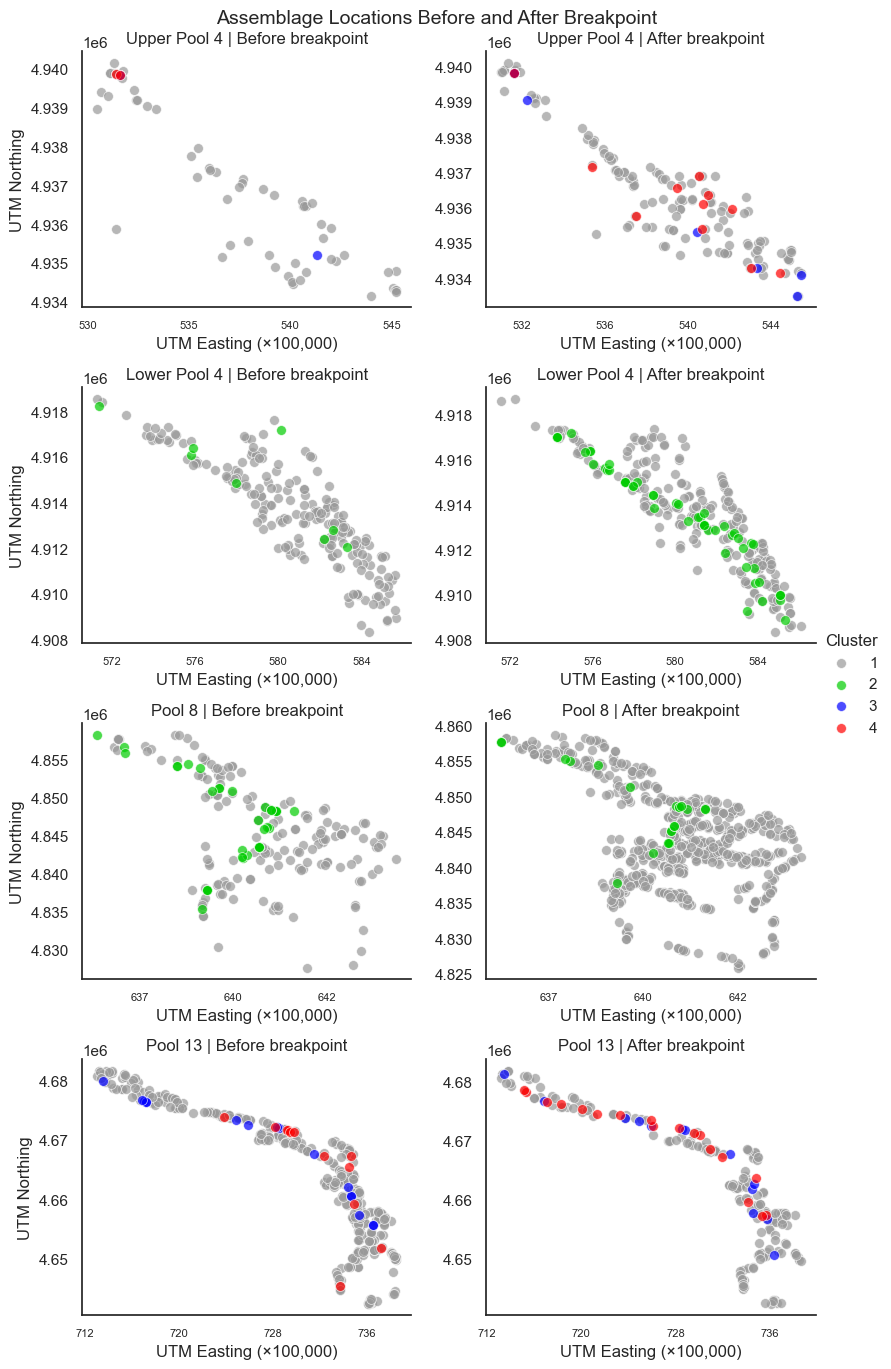

In [61]:
# ...existing code...
# Create FacetGrid with row=mode_pool, col=period
g = sns.FacetGrid(
    df_filtered,
    row="mode_pool",
    col="period",
    hue="cluster",
    palette=color_map,
    height=3.5,
    aspect=1.2,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7, s=50)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.figure.subplots_adjust(top=0.95)
g.figure.suptitle("Assemblage Locations Before and After Breakpoint", fontsize=14)

# Format horizontal (x) ticks in units of 100,000 (show values / 1e5)
import matplotlib.ticker as mticker
SCALE = 1e3

for ax_row in g.axes:
    for ax in ax_row:
        if ax is None:
            continue
        # limit number of ticks and show ticks in units of 100,000
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
        ax.xaxis.set_major_formatter(
            mticker.FuncFormatter(lambda x, pos: f"{int(x / SCALE):,}" if not np.isnan(x) else "")
        )
        # update label to indicate new units
        ax.set_xlabel("UTM Easting (×100,000)")
        ax.tick_params(axis="x", rotation=0, labelsize=8)

plt.show()
g.savefig(
    'assemblage_locations.jpg',
    dpi=300,
    bbox_inches='tight',
    format='jpeg',
    pil_kwargs={'quality': 95, 'optimize': True, 'progressive': True}
)

Figure X. Spatial distribution of fish assemblage clusters before and after estimated temporal breakpoints across four Upper Mississippi River pools. Points represent sampling locations in UTM coordinates; colors denote cluster ID (1 = red, 2 = green, 4 = blue) Rows correspond to pools (Pool4N, Pool4S, Pool8, Pool13), and columns separate time before and after the breakpoint year inferred from segmented regressions of annual cluster proportions. Plots highlight changes in the spatial footprint of dominant assemblage types across time periods.

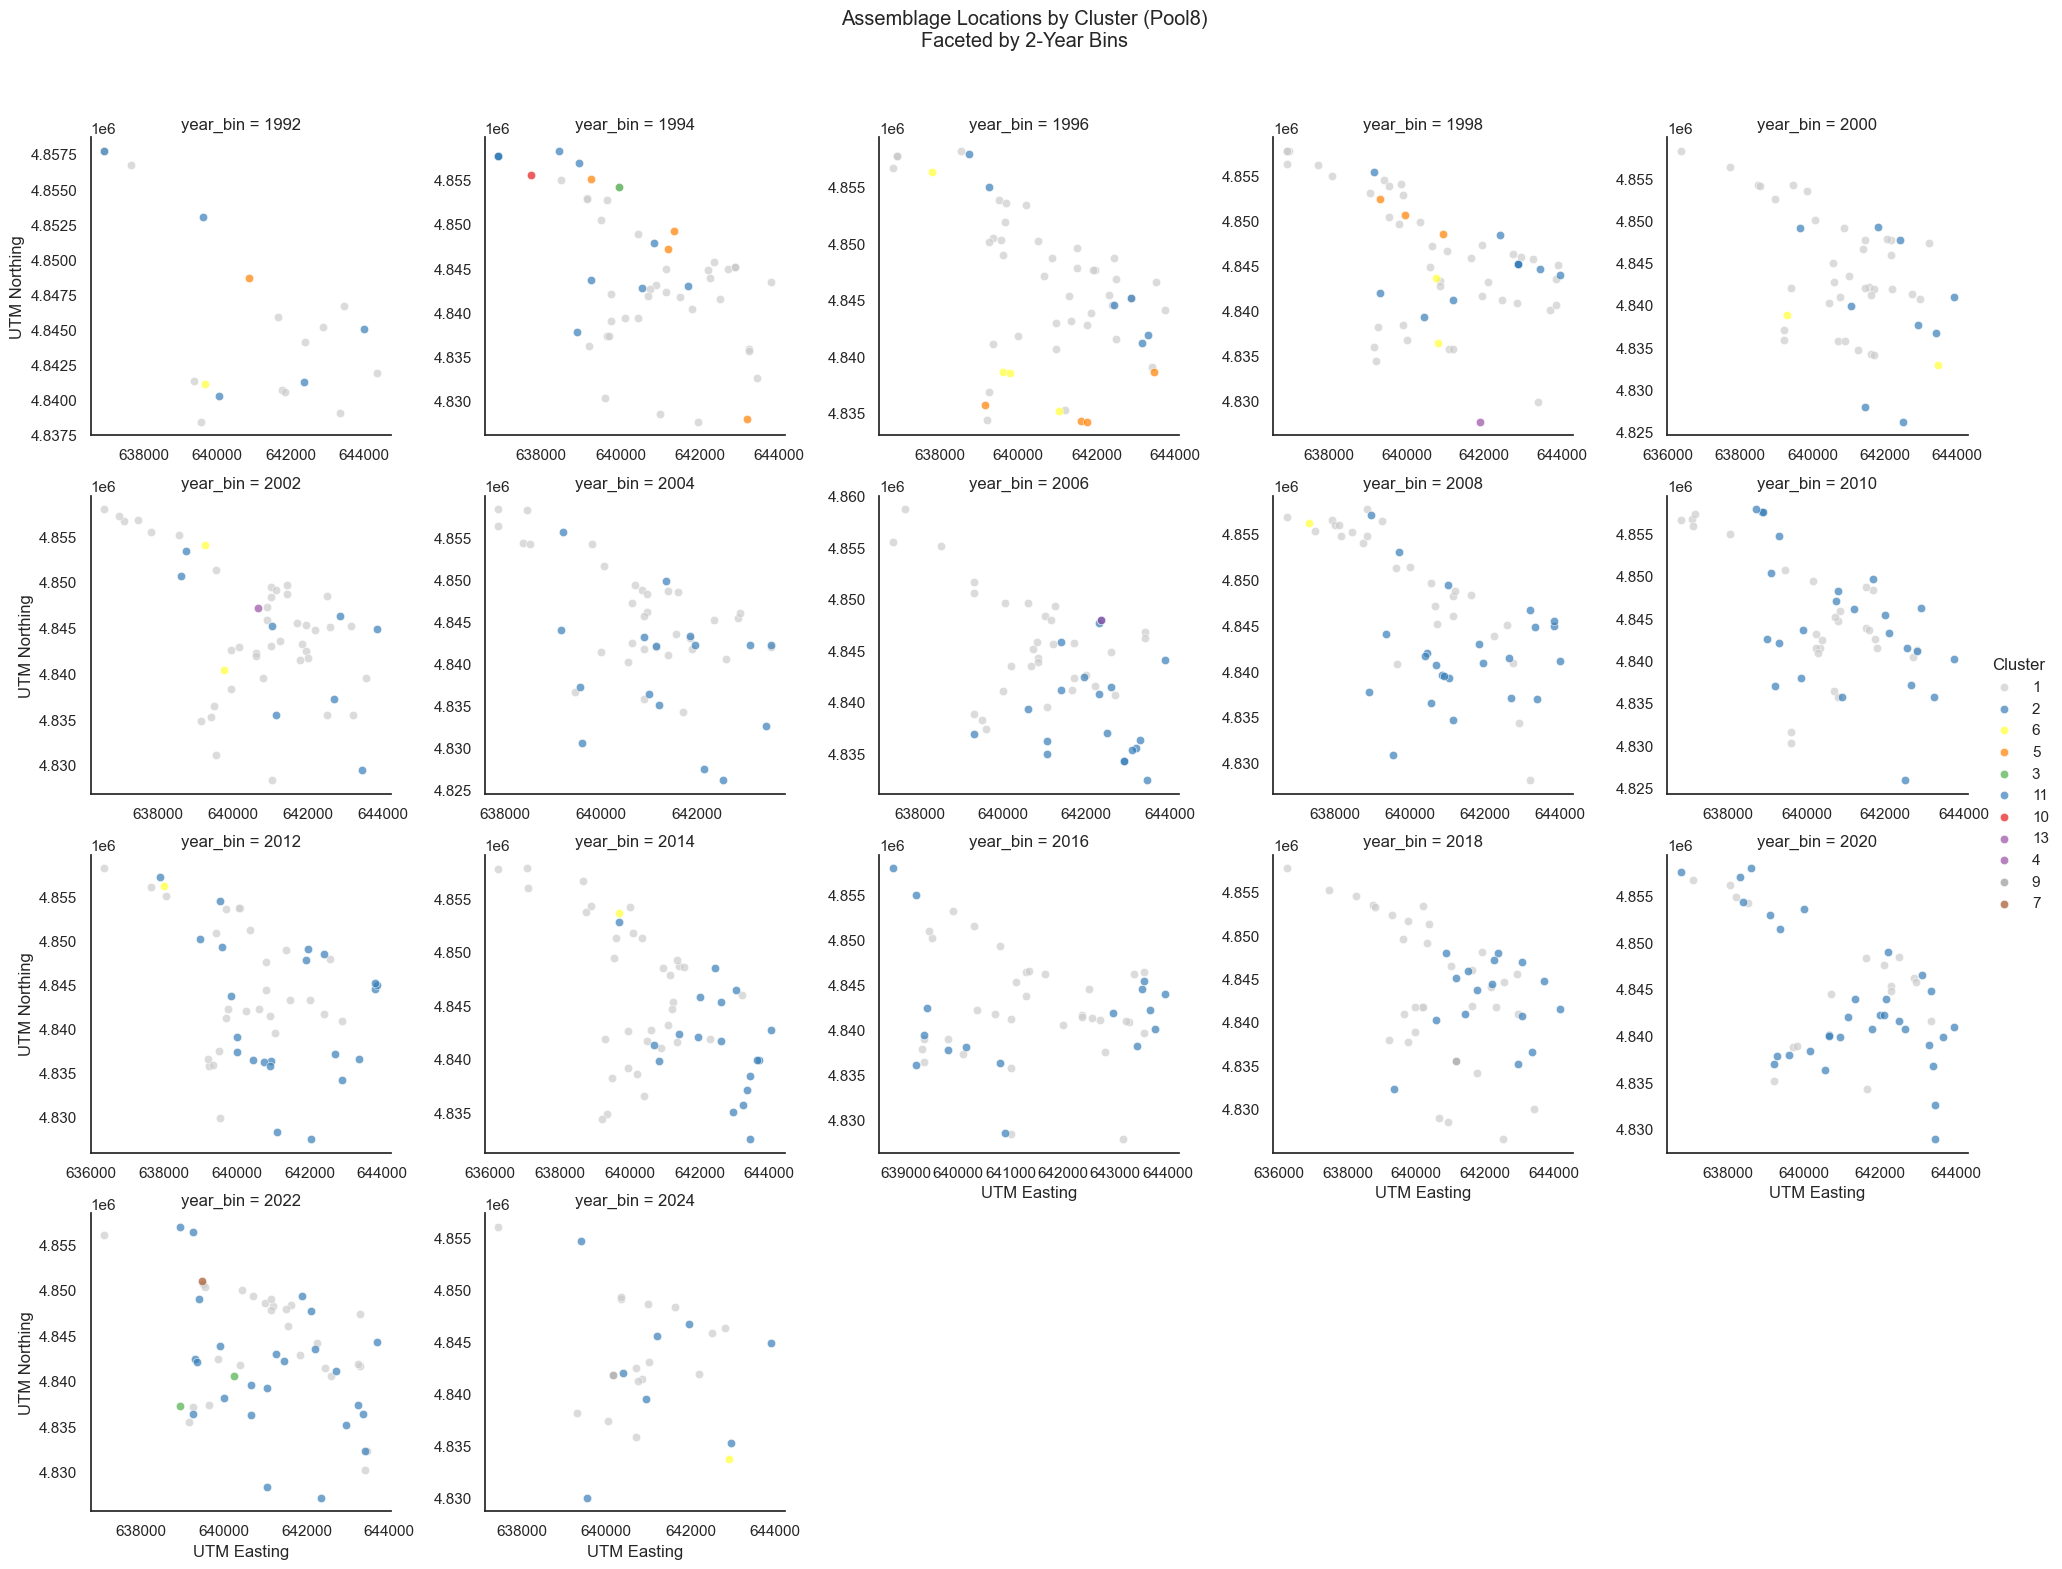

In [ ]:
# Use the same color_map as the global plot
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = cluster_sizes.idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {str(c): col for c, col in zip(unique_clusters, palette)}
color_map[str(largest_cluster)] = light_color

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()
    
    YEAR_BIN = 2
    # Create a new column for year bins
    df_pool['year_bin'] = ((df_pool['year']) // YEAR_BIN) * YEAR_BIN

    # Ensure cluster column is string type for consistency (optional, for legend order)
    df_pool['cluster'] = df_pool['cluster'].astype(str)

    # Create the FacetGrid using the global color_map
    g = sns.FacetGrid(
        df_pool,
        col="year_bin",
        col_wrap=5,
        height=4,
        sharex=False,
        sharey=False,
        hue="cluster",
        palette=color_map  # Use global color map for consistency
    )
    g.map_dataframe(
        sns.scatterplot,
        x="utm_e",
        y="utm_n",
        alpha=0.7
    )
    g.add_legend(title="Cluster")
    g.set_axis_labels("UTM Easting", "UTM Northing")
    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(f"Assemblage Locations by Cluster ({pool_filter})\nFaceted by {YEAR_BIN}-Year Bins")
    plt.show()


DFA for proportion of samples in each cluster over time, faceted by pool.

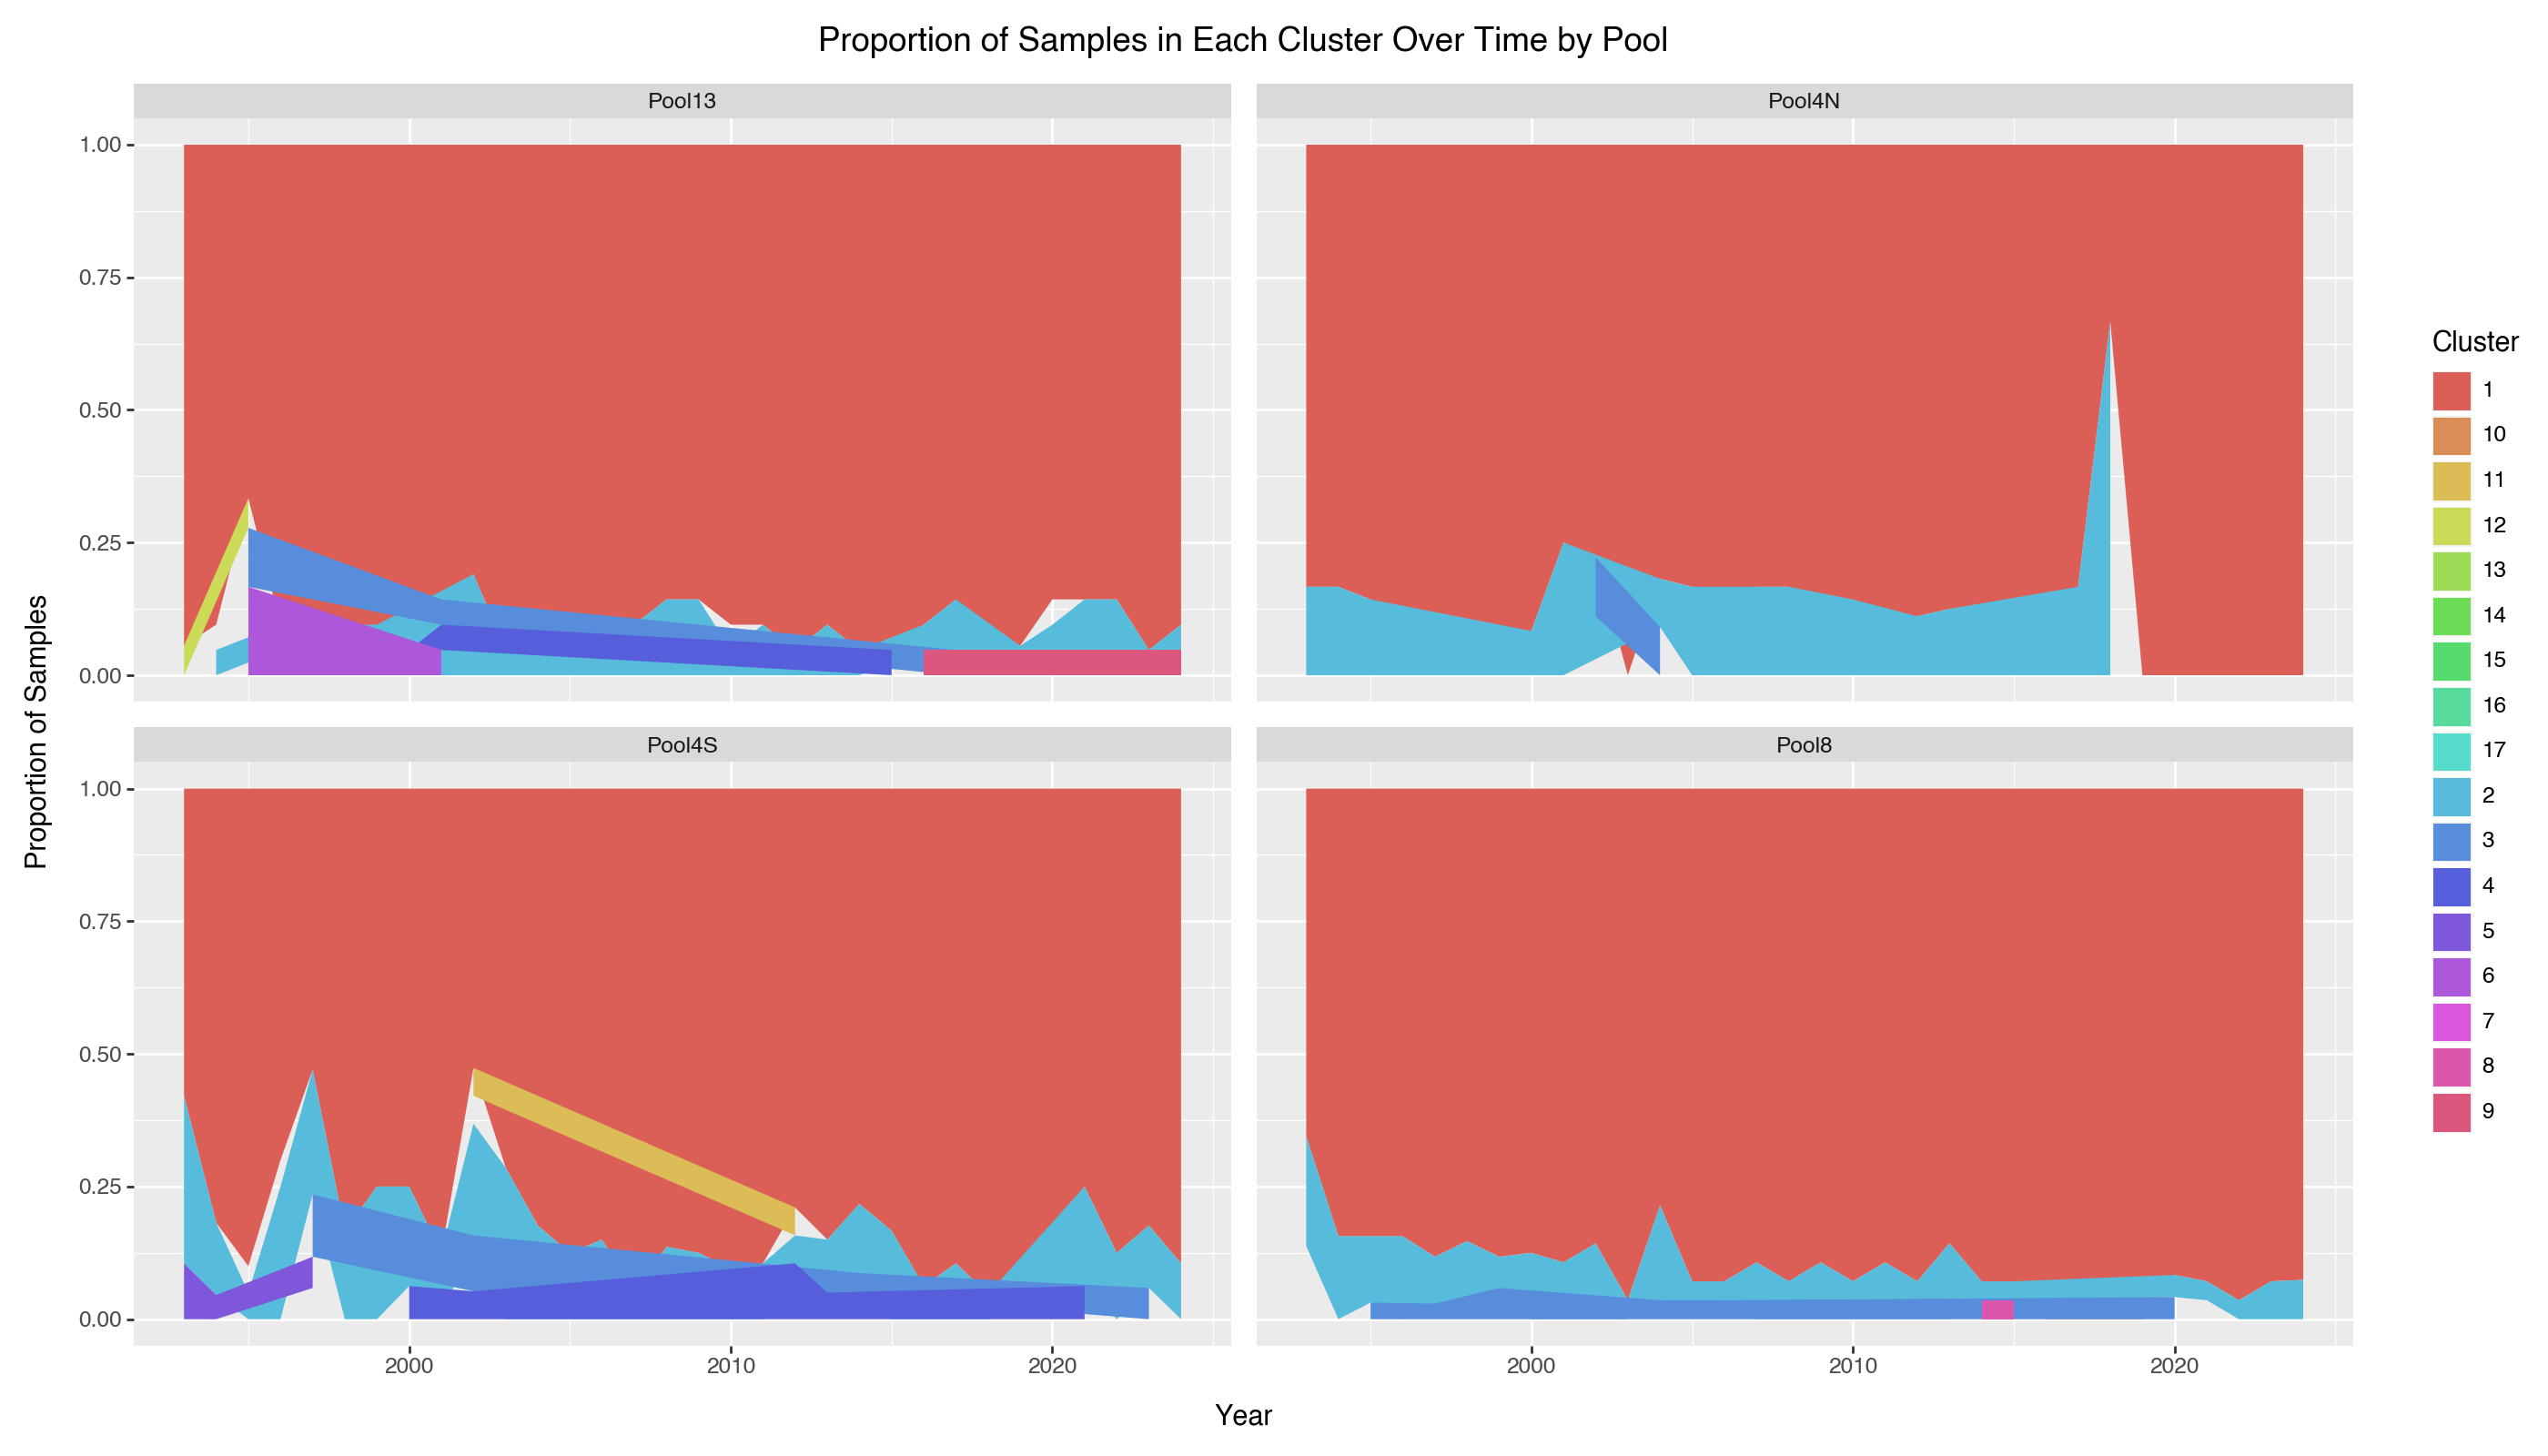

In [ ]:
# Prepare data for DFA-style analysis: proportion of samples in each cluster over time by pool
cluster_proportions = df_explore.groupby(['year', 'mode_pool', 'cluster']).size().reset_index(name='count')

# Calculate total samples per year per pool
totals = cluster_proportions.groupby(['year', 'mode_pool'])['count'].transform('sum')
cluster_proportions['proportion'] = cluster_proportions['count'] / totals

# Convert cluster to string for plotting
cluster_proportions['cluster'] = cluster_proportions['cluster'].astype(str)

# Create stacked area plot showing proportions over time, faceted by pool
(ggplot(cluster_proportions, aes(x='year', y='proportion', fill='cluster')) +
 geom_area(position='stack') +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster', 
    title='Proportion of Samples in Each Cluster Over Time by Pool') +
 theme(figure_size=(14, 8))
)

/var/folders/5f/8wj2hdcx4p14q972y40gpgpc0000gn/T/ipykernel_6921/1790906780.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


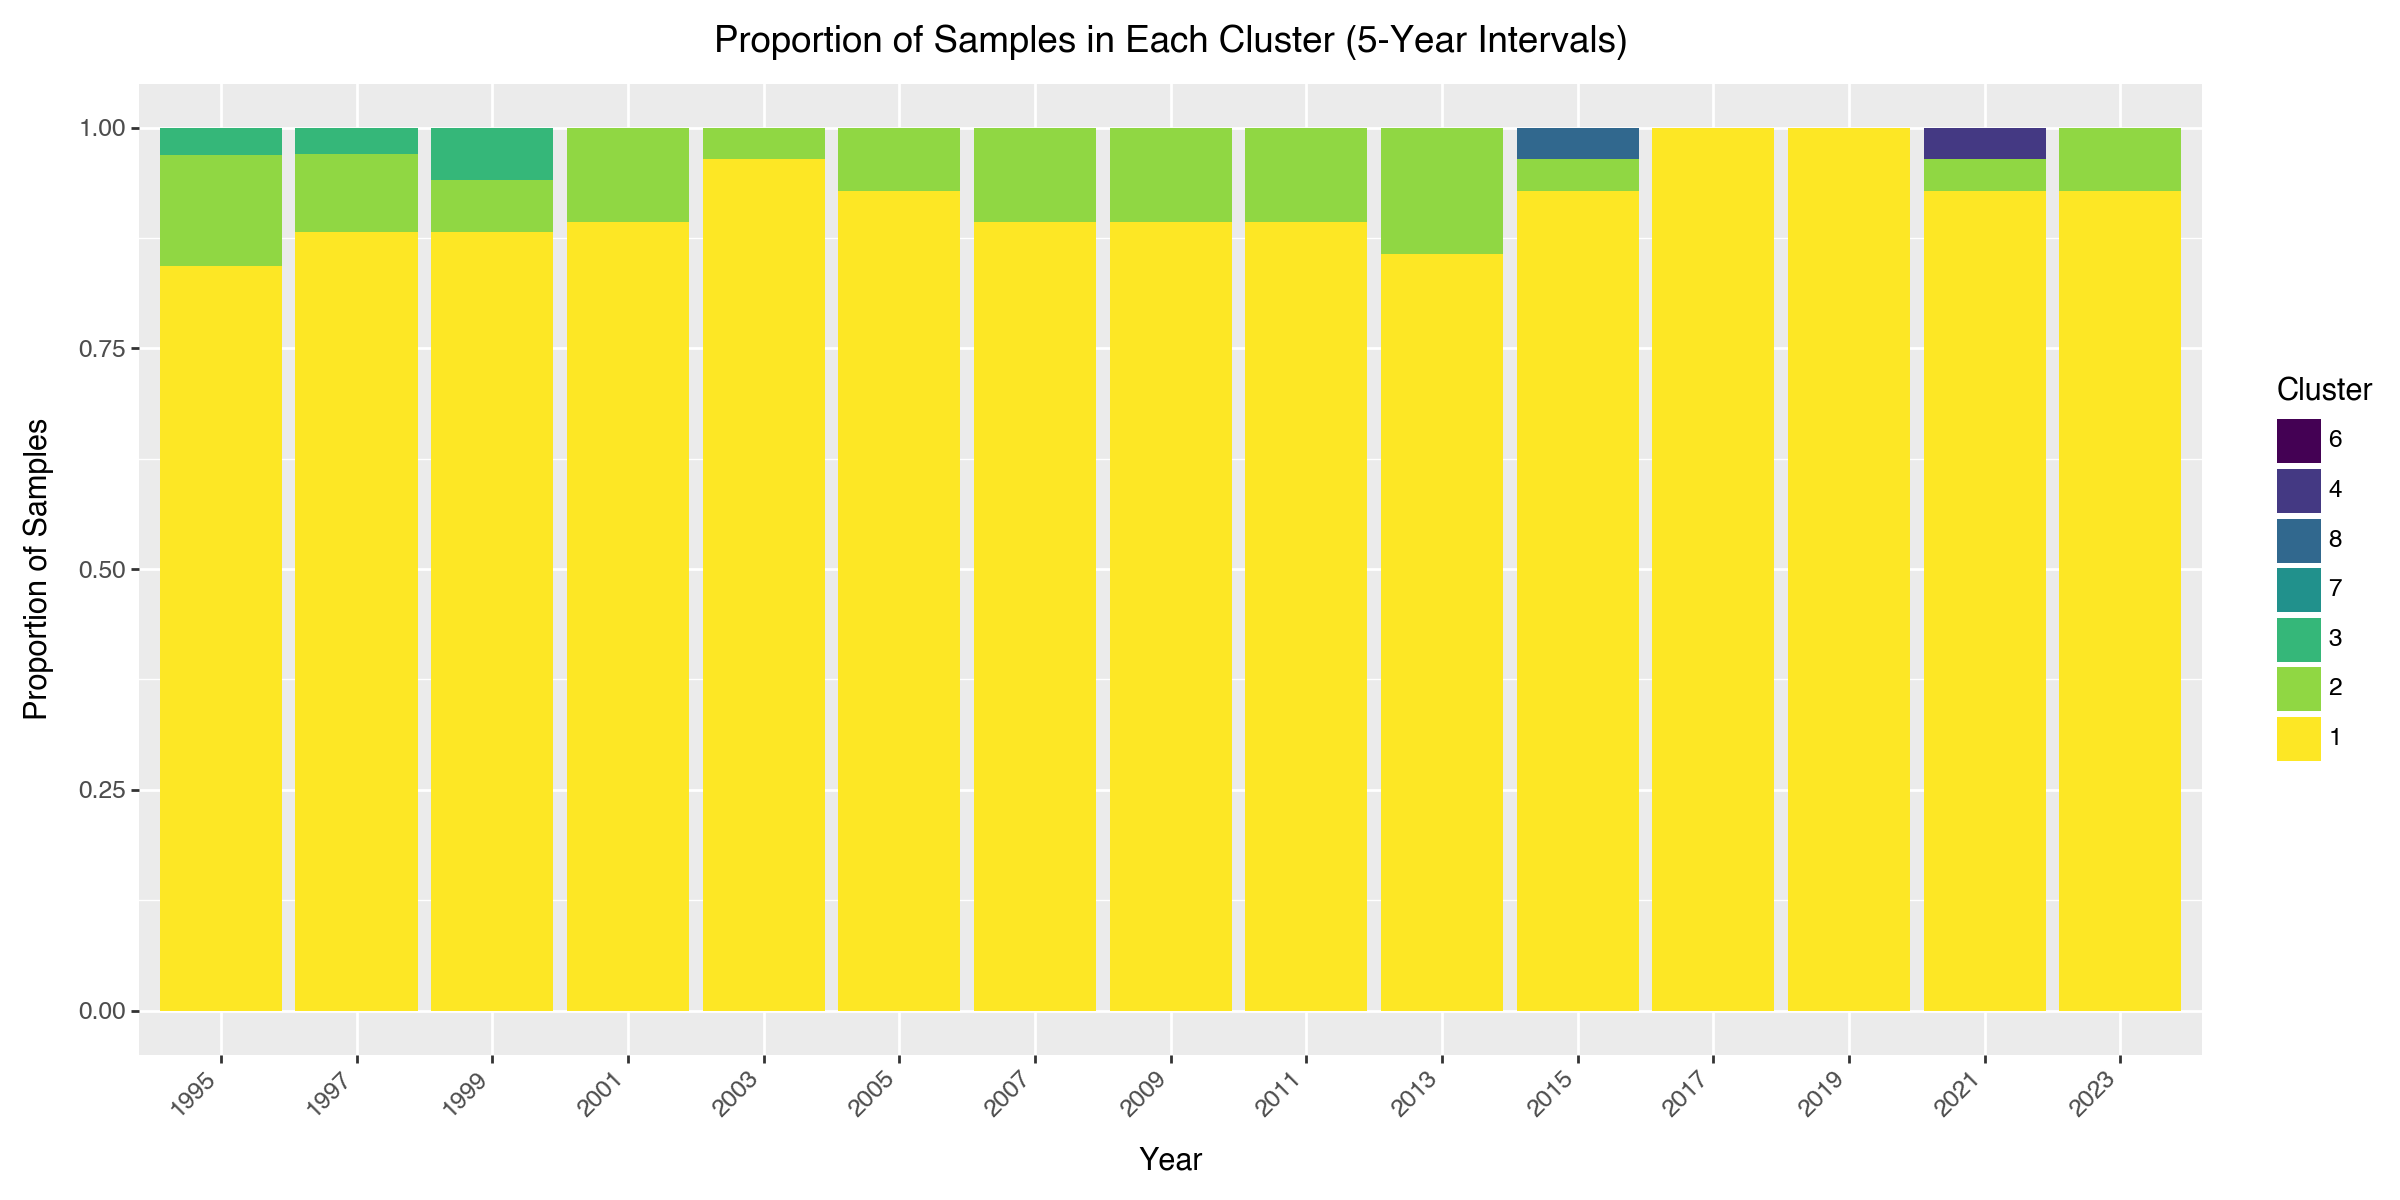

In [ ]:
# Prepare data for DFA-style analysis: proportion of samples in each cluster over time by pool
cluster_proportions = df_pool.groupby(['year', 'cluster']).size().reset_index(name='count')

# Calculate total samples per year per pool
totals = cluster_proportions.groupby(['year'])['count'].transform('sum')
cluster_proportions['proportion'] = cluster_proportions['count'] / totals


# Create a filtered dataset for specific years (1995, 2000, 2005, ...)
years_to_plot = list(range(1995, df_pool['year'].max() + 1, 2))

# Filter cluster_proportions for these years
cluster_proportions_filtered = cluster_proportions[cluster_proportions['year'].isin(years_to_plot)]

# Sort clusters by overall proportion (to create consistent ordering)
cluster_order = cluster_proportions.groupby('cluster')['proportion'].sum().sort_values(ascending=True).index.astype(str)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Create stacked bar plot
(ggplot(cluster_proportions_filtered, aes(x='factor(year)', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster', 
      title='Proportion of Samples in Each Cluster (5-Year Intervals)') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)

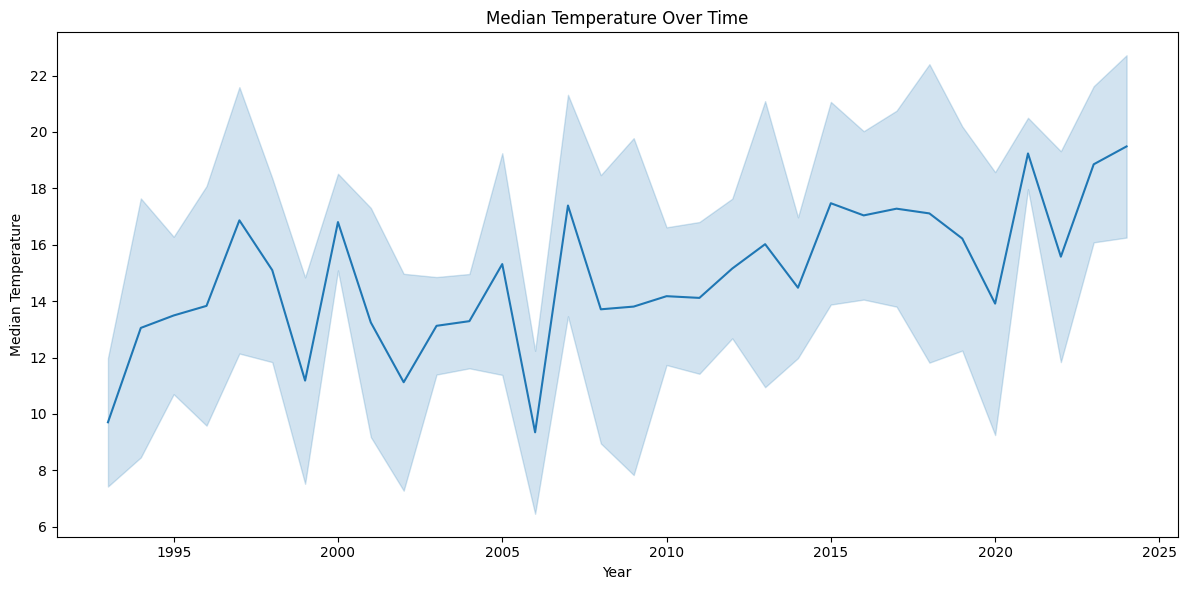

In [ ]:
# Plot median temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pool, x='year', y='median_temp', estimator='mean', errorbar='sd')
plt.xlabel('Year')
plt.ylabel('Median Temperature')
plt.title('Median Temperature Over Time')
plt.tight_layout()
plt.show()

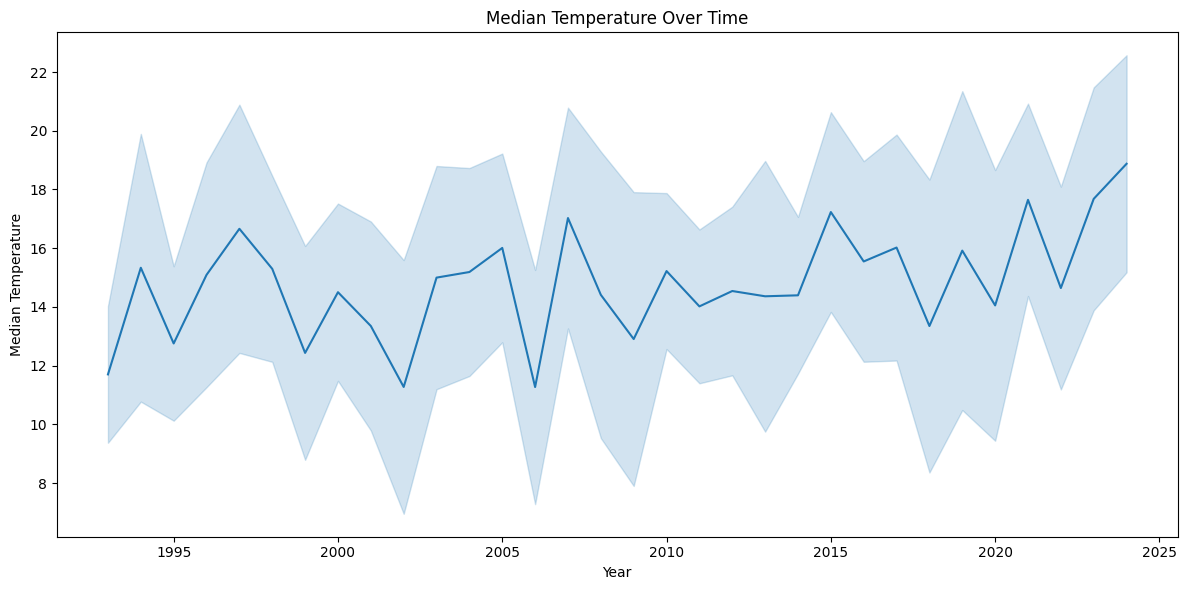

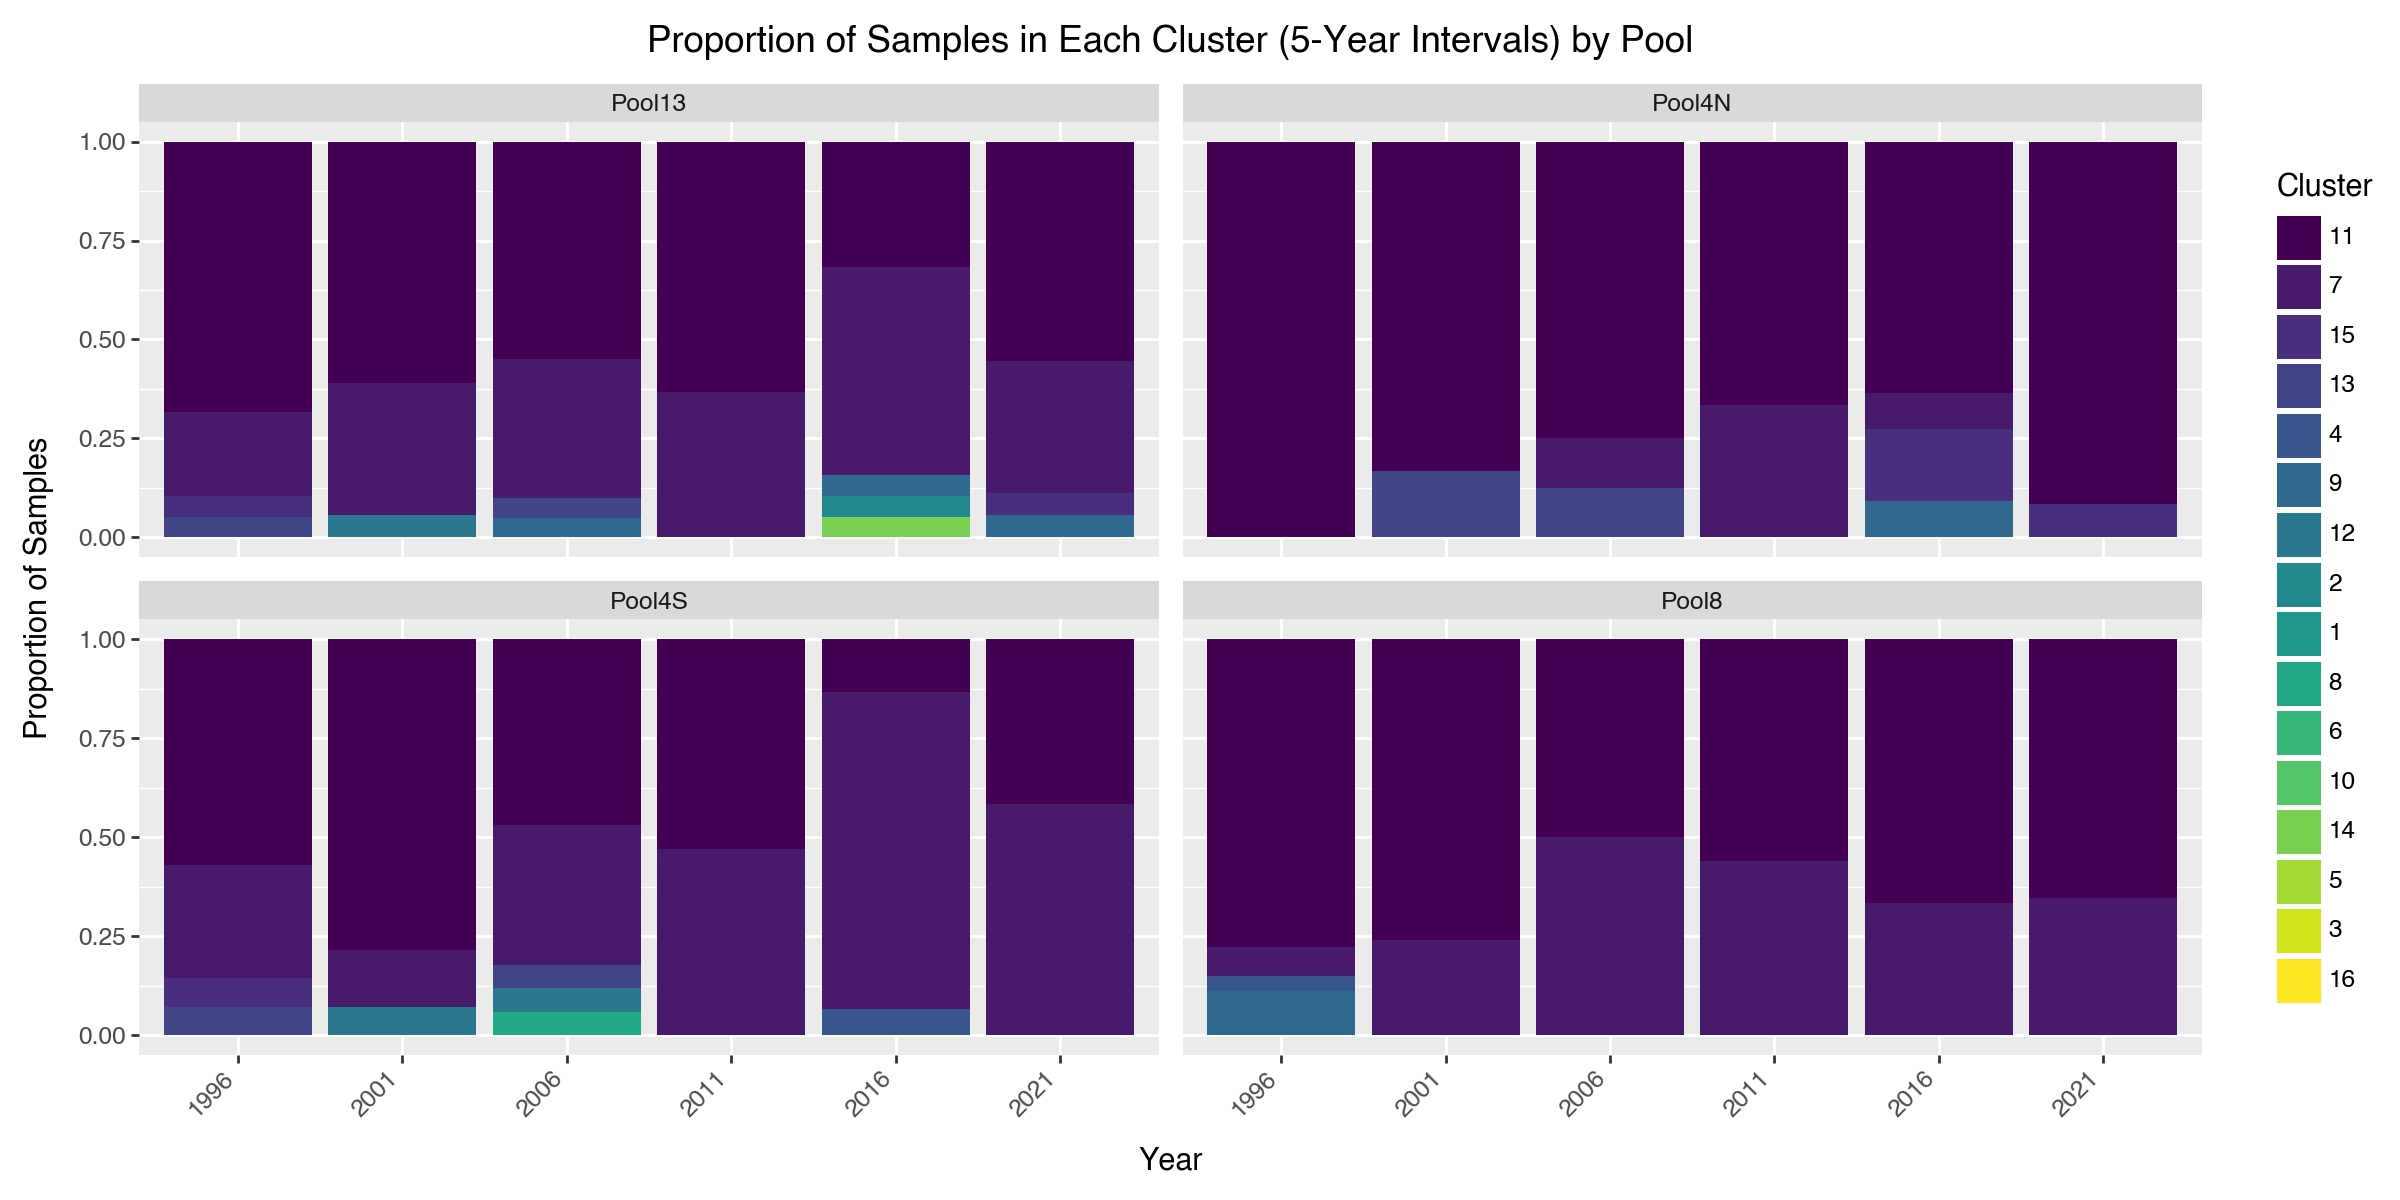

In [ ]:
# ...existing code...
# Create a filtered dataset for specific years (1995, 2000, 2005, ...)
years_to_plot = list(range(1996, df_explo['year'].max() + 1, 5))

# Filter cluster_proportions for these years (copy to avoid SettingWithCopy warnings)
cluster_proportions_filtered = (
    cluster_proportions.loc[cluster_proportions['year'].isin(years_to_plot)].copy()
)

# Sort clusters by overall proportion (to create consistent ordering)
cluster_order = (
    cluster_proportions.groupby('cluster')['proportion']
    .sum()
    .sort_values(ascending=False)
    .index.astype(str)
)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Make year an ordered categorical so bars are chronological
cluster_proportions_filtered['year'] = pd.Categorical(
    cluster_proportions_filtered['year'],
    categories=years_to_plot,
    ordered=True
)

# Create stacked bar plot faceted by pool
from plotnine import *
(ggplot(cluster_proportions_filtered, aes(x='year', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Proportion of Samples', fill='Cluster',
      title='Proportion of Samples in Each Cluster (5-Year Intervals) by Pool') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)
# ...existing code...

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 65 rows containing missing values.


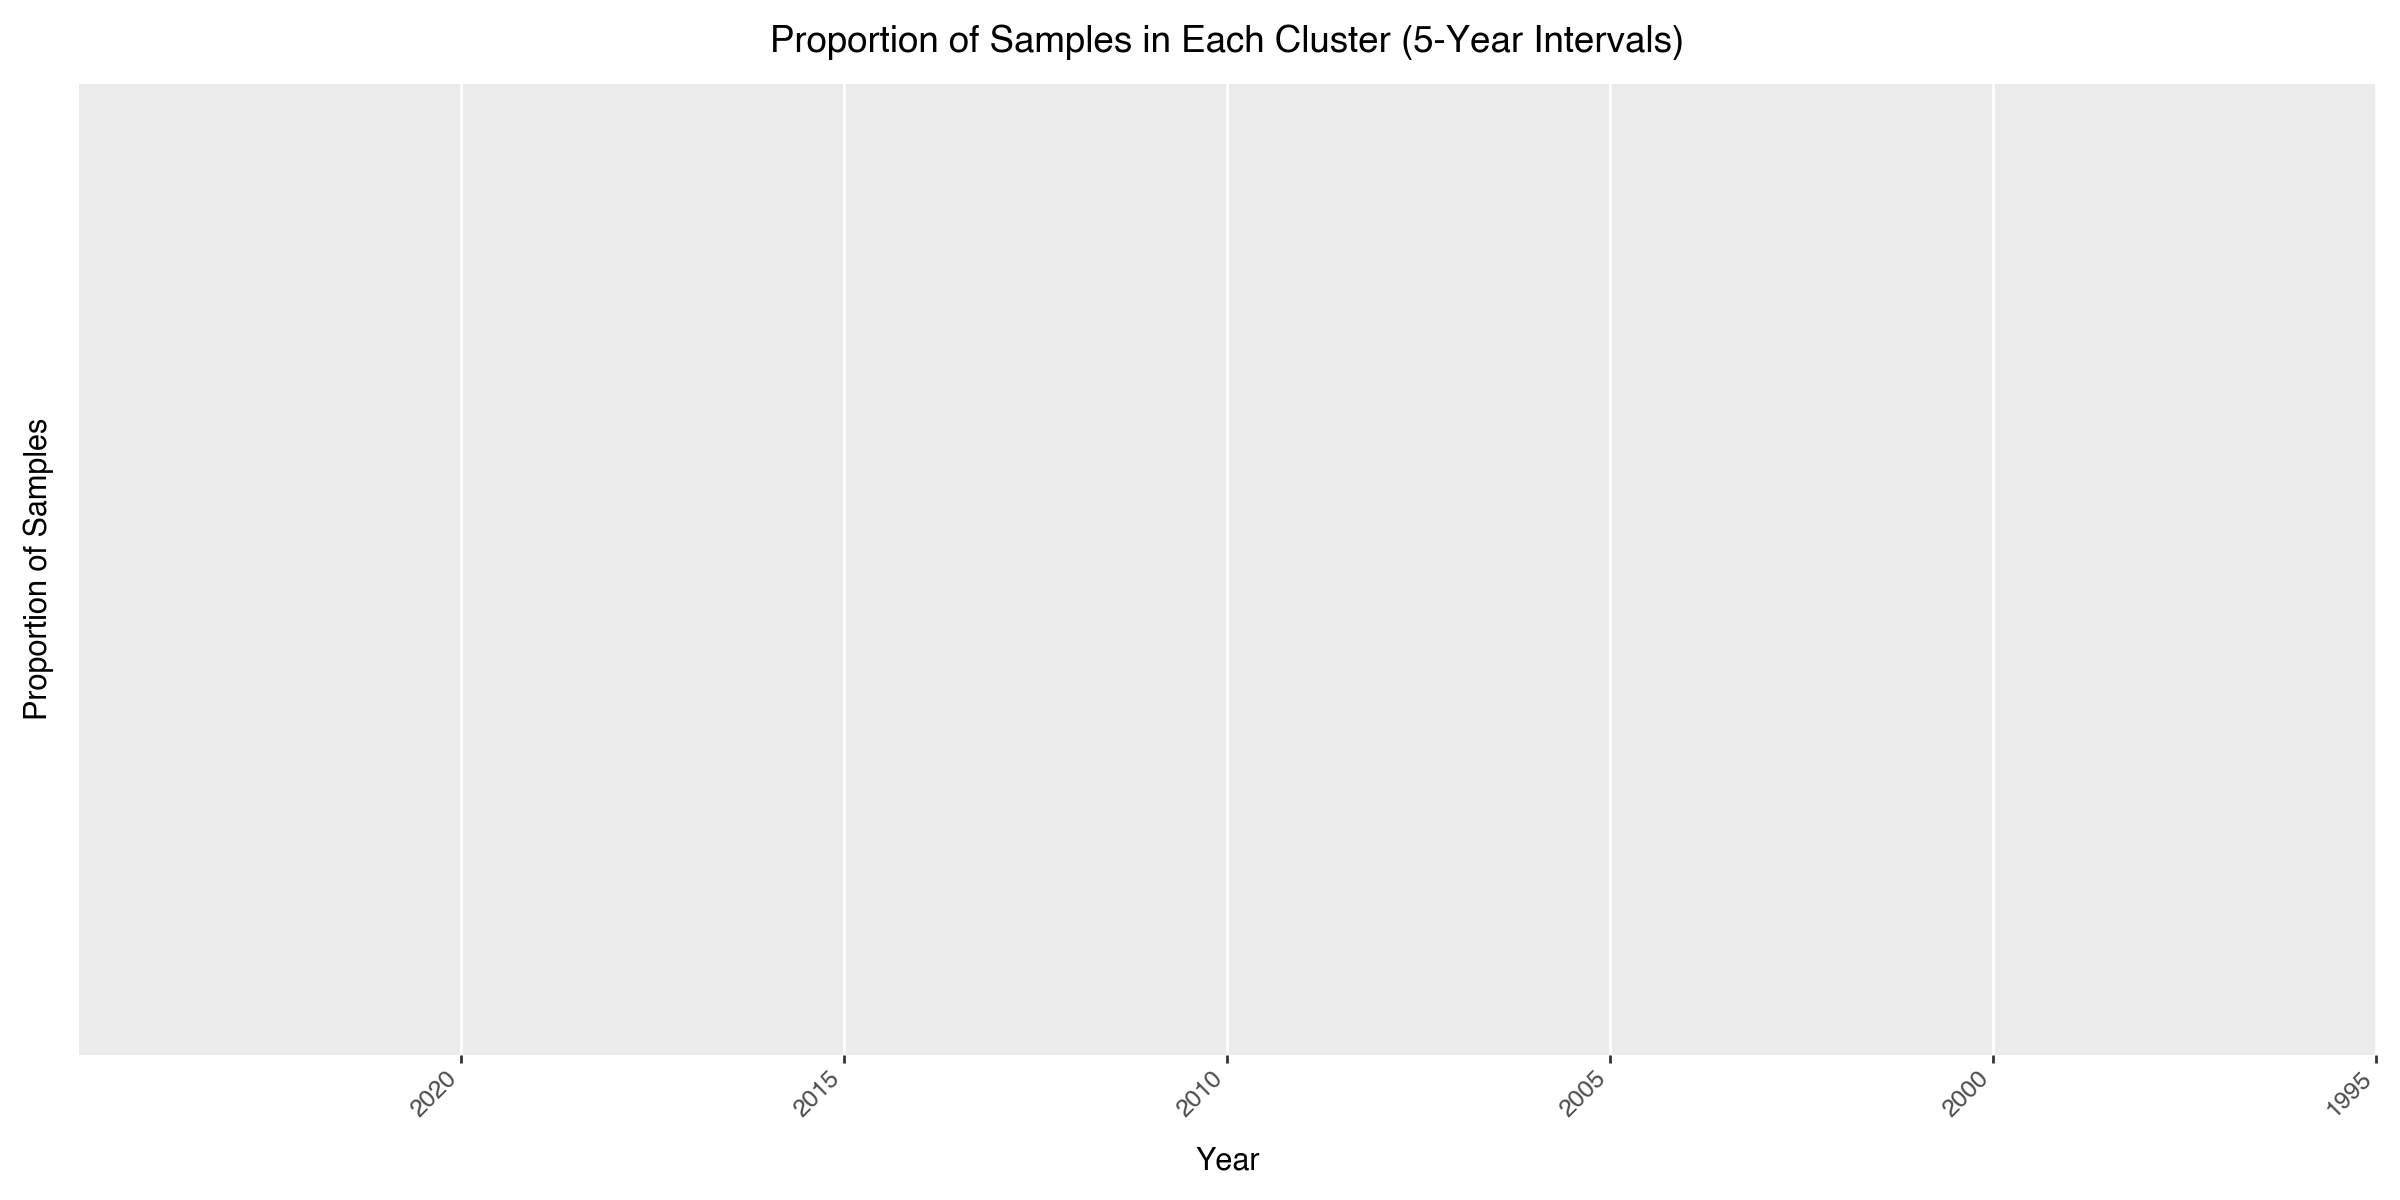

In [ ]:
# ...existing code...
# Sort clusters by overall proportion (reverse order)
cluster_order = (
    cluster_proportions.groupby('cluster')['proportion']
    .sum()
    .sort_values(ascending=True)  # was descending
    .index.astype(str)
)

# Ensure cluster is string and convert to categorical with specified order
cluster_proportions_filtered['cluster'] = pd.Categorical(
    cluster_proportions_filtered['cluster'].astype(str),
    categories=cluster_order,
    ordered=True
)

# Create stacked bar plot with reversed x (years) order
from plotnine import *
(ggplot(cluster_proportions_filtered, aes(x='factor(year)', y='proportion', fill='cluster')) +
 geom_col(position='stack') +
 scale_x_discrete(limits=[str(y) for y in years_to_plot[::-1]]) +
 labs(x='Year', y='Proportion of Samples', fill='Cluster',
      title='Proportion of Samples in Each Cluster (5-Year Intervals)') +
 theme(figure_size=(12, 6), axis_text_x=element_text(angle=45, hjust=1))
)
# ...existing code...